# Importing Files

In [46]:
DATA_DIR = 'Text_File/Master_Data--TD_1-30_CSVFiles/Subjects_1-30-inw1_through_osw1'
SAVE_DIR = 'Analysis'
GATE_CROSSING = -0.3
FREQUENCY = 128
PACE = 'normal'

In [3]:
RIGHT_AVY_HEADER = 'Angular Velocity Y (rad/s).2'
LEFT_AVY_HEADER = 'Angular Velocity Y (rad/s).3'
COLUMNS_TO_GRAPH = ['Acceleration Y (m/s^2)',  'Angular Velocity Y (rad/s)',##right thigh 
                    'Acceleration Y (m/s^2).1','Angular Velocity Y (rad/s).1',##left thigh
                    'Acceleration Y (m/s^2).2', RIGHT_AVY_HEADER,##right shank
                    'Acceleration Y (m/s^2).3',LEFT_AVY_HEADER ]##left shank
tmp = []
for val in COLUMNS_TO_GRAPH:
  tmp.append(val.replace('Y','X'))
  tmp.append(val.replace('Y','Z'))
COLUMNS_TO_GRAPH.extend(tmp)

COLUMNS_TO_AREA = {  'Acceleration Y (m/s^2)':'right thigh',  'Angular Velocity Y (rad/s)':'right thigh',##right thigh 
                    'Acceleration Y (m/s^2).1':'left thigh','Angular Velocity Y (rad/s).1':'left thigh',##left thigh
                    'Acceleration Y (m/s^2).2':'right shank', RIGHT_AVY_HEADER:'right shank',##right shank
                    'Acceleration Y (m/s^2).3':'left shank',LEFT_AVY_HEADER:'left shank' }##left shank     
tmp = list(COLUMNS_TO_AREA.items())
for val in tmp:
  COLUMNS_TO_AREA[val[0].replace('Y','X')] = val[1]
  COLUMNS_TO_AREA[val[0].replace('Y','Z')] = val[1]
COLUMNS_TO_LEG = {}
for k in list(COLUMNS_TO_AREA.keys()):
  COLUMNS_TO_LEG[k]=COLUMNS_TO_AREA[k].split(' ')[0]
COLUMNS_BY_SENSOR = [{'sensor':'thigh','right':'Acceleration Y (m/s^2)','left': 'Acceleration Y (m/s^2).1'}, 
                     {'sensor':'thigh','right':'Angular Velocity Y (rad/s)', 'left':'Angular Velocity Y (rad/s).1'},
                     {'sensor':'shank','right':'Acceleration Y (m/s^2).2','left':'Acceleration Y (m/s^2).3'},
                     {'sensor':'shank','right':RIGHT_AVY_HEADER, 'left':LEFT_AVY_HEADER},]    
tmp = COLUMNS_BY_SENSOR.copy()        
for d in tmp:
   COLUMNS_BY_SENSOR.append({'sensor':d['sensor'], 'right':d['right'].replace('Y','X'), 'left':d['left'].replace('Y','X')})
   COLUMNS_BY_SENSOR.append({'sensor':d['sensor'], 'right':d['right'].replace('Y','Z'), 'left':d['left'].replace('Y','Z')})   

In [4]:

import os
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  
  print("Colab: mounting Google drive on ", mount)
  drive.mount(mount, force_remount=True)
  

  # Switch to the directory on the Google Drive that you want to use

  drive_root = mount + "/MyDrive/Adult/2022/Deep_Kahlon/Walking_Opal_Research/13_Data/TD_data/"
  #drive_root = mount + "/MyDrive/Walking_Opal_Research/13_Data/TD_data/" 
  #drive_root = mount + "/MyDrive/Walking_Opal_Research/13_Data/TD_data/"


  # Create drive_root if it doesn't exist
  create_drive_root = False
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: Changing directory to  /content/gdrive/MyDrive/Adult/2022/Deep_Kahlon/Walking_Opal_Research/13_Data/TD_data/
/content/gdrive/.shortcut-targets-by-id/1P7-TiZy5FtPsC-TWb3r-avvL2uj8dZE5/Walking_Opal_Research/13_Data/TD_data


In [186]:
import os
import glob
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import Counter
import random
from typing import List, Tuple
from scipy.spatial import distance
#from scipy.signal import resample
from scipy.signal import correlate, find_peaks, butter, sosfilt
from scipy.interpolate import interp1d

In [6]:
gate_files = [os.path.basename(x) for x in glob.glob(os.path.join(DATA_DIR,"*.csv"))]

print(len(gate_files), "data files found")
print("first couple")
print(gate_files[:5])

268 data files found
first couple
['20220817-105702-subject_01inw1.csv', '20220820-200639-subject_02isw1.csv', '20220823-140901-subject_03onw1.csv', '20220823-135108-subject_03ifw1.csv', '20220825-102740-subject_05isw2.csv']


In [7]:
def extract_trial_data(filename, verbose=False):
  end_part = filename.split('_')[1].replace('.csv','')
  subjectID_str = ''.join([x for x in end_part[:3] if x.isdigit()])
  subjectID =int(subjectID_str)
  end_part= end_part.replace(subjectID_str, '', 1)
  trial =int(''.join([x for x in end_part if x.isdigit()]))
  end_part= end_part.replace(str(trial), '')
  inout = 'outdoors' if ('o' in end_part) else 'indoors'
  pace = end_part[1]
  if pace=='s':
    pace = 'slow'
  elif pace =='f':
    pace ='fast'
  elif pace =='n':
    pace='normal'
  timestamp = datetime.datetime.strptime(filename.split('-')[0], '%Y%m%d')
  if verbose:
    print("filename:", filename)
    print("subjectID:", subjectID)
    print("indoor/outdoor:", inout)
    print("trial:", trial)
    print("pace:", pace)
    print("data collected on:", timestamp)
  return subjectID, inout, pace, trial, timestamp

In [8]:
metadata_list = []
for file in gate_files:
  subjectID, inout, pace, trial, timestamp = extract_trial_data(file, verbose=False)
  metadata_list.append([file, subjectID, inout, pace, trial, timestamp])
metadata = pd.DataFrame(metadata_list, columns=['filename', 'subjectID', 'inout', 'pace', 'trial', 'timestamp'])
metadata

filename  subjectID     inout    pace  trial  \
0    20220817-105702-subject_01inw1.csv          1   indoors  normal      1   
1    20220820-200639-subject_02isw1.csv          2   indoors    slow      1   
2    20220823-140901-subject_03onw1.csv          3  outdoors  normal      1   
3    20220823-135108-subject_03ifw1.csv          3   indoors    fast      1   
4    20220825-102740-subject_05isw2.csv          5   indoors    slow      2   
..                                  ...        ...       ...     ...    ...   
263  20221220-165302-subject_25osw1.csv         25  outdoors    slow      1   
264  20221220-164624-subject_25onw1.csv         25  outdoors  normal      1   
265  20221220-164945-subject_25ofw1.csv         25  outdoors    fast      1   
266  20221106-110259-subject_25ifw2.csv         25   indoors    fast      2   
267  20221106-111407-subject_25isw2.csv         25   indoors    slow      2   

     timestamp  
0   2022-08-17  
1   2022-08-20  
2   2022-08-23  
3   2022-08-23  
4   2022-08-25  
..         ...  
263 2022-12-20  
264 2022-12-20  
265 2022-12-20  
266 2022-11-06  
267 2022-11-06  

[268 rows x 6 columns]

In [9]:
##filter out only the normal walking pace
metadata = metadata.loc[metadata['pace']==PACE]
metadata.reset_index(inplace=True, drop=True)
metadata

filename  subjectID     inout    pace  trial  \
0   20220817-105702-subject_01inw1.csv          1   indoors  normal      1   
1   20220823-140901-subject_03onw1.csv          3  outdoors  normal      1   
2   20220825-103542-subject_05onw1.csv          5  outdoors  normal      1   
3   20220824-111447-subject_04inw2.csv          4   indoors  normal      2   
4   20220820-202012-subject_02onw1.csv          2  outdoors  normal      1   
..                                 ...        ...       ...     ...    ...   
85  20221113-114232-subject_27onw1.csv         27  outdoors  normal      1   
86  20221119-103754-subject_30onw1.csv         30  outdoors  normal      1   
87  20221119-100727-subject_30inw2.csv         30   indoors  normal      2   
88  20221119-100257-subject_30inw1.csv         30   indoors  normal      1   
89  20221220-164624-subject_25onw1.csv         25  outdoors  normal      1   

    timestamp  
0  2022-08-17  
1  2022-08-23  
2  2022-08-25  
3  2022-08-24  
4  2022-08-20  
..        ...  
85 2022-11-13  
86 2022-11-19  
87 2022-11-19  
88 2022-11-19  
89 2022-12-20  

[90 rows x 6 columns]

## Preprocessing

In [10]:
def remove_ends_data(df_p,remove_seconds: float =5, verbose=False):
  '''warning, this changes the data in memory every time it is run
  do not run multiple times on the same data
  remove_seconds: seconds on begining and end to remove '''
  if verbose:
    print("shape before removing intro and tail ", df_p.shape)
  n_remove = remove_seconds*FREQUENCY
  df_p.drop(index=df_p.index[:n_remove], axis=0, inplace=True)
  # Using DataFrame.tail() function to drop first n rows
  df_p = df_p.tail(-n_remove)
  if verbose:
    print("shape after removing intro and tail ", df_p.shape)
  return df_p
  

In [11]:
def low_pass_butterworth(df_b, N: int=4, Wn: float = 20):
  sos=butter(N, Wn, btype='lowpass', analog=False, output='sos', fs=FREQUENCY)
  for col in COLUMNS_TO_GRAPH:
    filtered = sosfilt(sos, df_b[col].values)
    #for i in range(df_b.shape[0]):
    #  df_b.loc[i, col]=filtered[i]
    df_b[col]=pd.Series(filtered, name=col)
    #df_b = df_b.assign(col=sosfilt(sos, df_b[col]))
  return df_b

## Load Data

def apply_rolling_window(df_p, rolling_window=3, verbose=False):
  '''warning, this changes the data in memory every time it is run
  do not run multiple times on the same data
  Noise causes the values to jump around zero making the exact real zero 
  crossing hard to define a moving avg filter is applied'''
  for column in COLUMNS_TO_GRAPH:
    df_p[column] = df_p[column].rolling(rolling_window).mean()
  df_p.drop(index=df_p.index[:rolling_window-1], axis=0, inplace=True)
  df_p.reset_index(inplace=True)    
  if verbose:
    print("shape after rolling window ", df_p.shape)

In [12]:
def load_data(filename:str, low_pass: bool = True, N: int=4, Wn:float=20):
  '''takes in only the filename, not the path'''
  df_a = pd.read_csv(os.path.join(DATA_DIR, filename), usecols=COLUMNS_TO_GRAPH)
  df_in = remove_ends_data(df_a)
  if low_pass:
    return low_pass_butterworth(df_in, N=N, Wn=Wn)
  else:
     return df_in

The details of the chosen file are displayed below

In [13]:
start = datetime.datetime.now()
data_lookup = {}
for filename in metadata['filename']:
  data_lookup[filename]=load_data(filename)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

<ipython-input-11-dbd2e45ec838>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b[col]=pd.Series(filtered, name=col)


In [16]:
file =metadata['filename'].iloc[random.randint(0,metadata.shape[0]-1)]
df = data_lookup[file]
extract_trial_data(file, verbose=True)
print("number data points per data stream", df.shape[0])

filename: 20221113-101430-subject_26inw2.csv
subjectID: 26
indoor/outdoor: indoors
trial: 2
pace: normal
data collected on: 2022-11-13 00:00:00
number data points per data stream 21760


In [17]:
##print_metadata
with open(os.path.join(DATA_DIR, file), 'r') as fileobj:
  ct = 0 
  for line in fileobj.readlines():
    ct +=1
    print(line.split(',')[0])
    if ct ==14:
      break

Metadata
File Format Version=6
Monitor Case IDs= :SI-001572:SI-001562:SI-001559:SI-001573
Monitor Labels= :R Thigh:L Thigh:R Shank 1510 R:L Shank 1801
Version String1=APDM Inc.
Version String2=2016-10-04-3cdef2ce2a3717c4e8eddcd0e0bd391ede8550fd
Version String3=2019-05-29 18:10:14 monitor_hv11_bv2_20161006_3cdef2ce.hex
Calibration Version=6
Sample Rate=128
Decimation Factor=1
Time Good=0
Decimation Bypass=0
Gravity=9.806000
Magnetic field magnitude=53.200000


## Low Pass Filter

In [18]:
def generate_examples_of_butter_filter(zero_crossing_lookup, metadata,  N:int = 4, Wn:float = 20, column:str = LEFT_AVY_HEADER):
  ##grab a random file and a random gate
  for i in range(20):
    file = metadata['filename'].iloc[random.randint(0,metadata.shape[0]-1)]
    
    df_filtered = load_data(file, low_pass = True, N=N, Wn=Wn)
    df = load_data(file, low_pass = False)
    zero_crossings = zero_crossing_lookup[file]['right']
    gate_ind = random.randint(0,len(zero_crossings)-2)
    center = zero_crossings[gate_ind][0]
    points = df[column].values[center-1*FREQUENCY:center+1*FREQUENCY]
    points_filtered = df_filtered[column].values[center-1*FREQUENCY:center+1*FREQUENCY]
    t = np.array([x for x in range(len(points))])/FREQUENCY
    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
    ax1.plot(t, points)
    ax1.set_title('Raw signal 2s')
    ax1.grid(visible=True)
    ax2.plot(t, points_filtered)
    ax2.set_title(" center " + str(center)+" N="+str(N)+", Wn="+str(Wn))
    ax2.grid(visible=True)
    print()
    _=fig.suptitle(file+" "+column+ " " + COLUMNS_TO_AREA[column])
    filter_dir = os.path.join("Analysis", "butterworth_examples")
    if not os.path.exists(filter_dir):
      os.mkdir(filter_dir)
    image_name = file.replace(".csv", '')+ " center " +str(center)+'.png'
    fig.savefig(os.path.join(filter_dir, image_name) )

### Messing with Butterworth filter - skip section

<ipython-input-208-dbd2e45ec838>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b[col]=pd.Series(filtered, name=col)


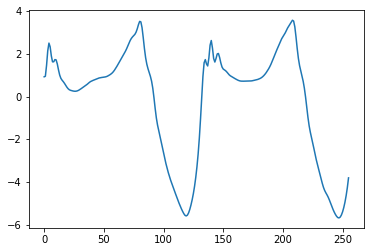

In [ ]:
#file = '20221009-172428-subject_17inw2.csv'
#center = 1376
#file ="20220823-134741-subject_03inw2.csv"
#center = 1061
file = "20221009-183118-subject_18inw1.csv"
center = 11843
df = load_data(file)
points = df[LEFT_AVY_HEADER].values[center-1*FREQUENCY:center+1*FREQUENCY]
plt.plot(points)

In [ ]:
t = np.array([x for x in range(len(points))])/FREQUENCY
fig, (ax1,ax15, ax2, ax3) = plt.subplots(4, 1, sharex=True, figsize=(12,16))
ax1.plot(t, points)
ax1.set_title('Raw signal 2s')
ax1.grid(visible=True)
ax15
sos05 = butter(4, 15, 'lowpass', fs=FREQUENCY,analog=False, output='sos')
filtered05 = sosfilt(sos05, points)
ax15.plot(t, filtered05)
ax15.set_title('After 15 Hz low-pass filter')
ax15.set_xlabel('Time [seconds]')
ax15.grid(visible=True)
sos = butter(4, 20, 'lowpass', fs=FREQUENCY,analog=False, output='sos')
filtered = sosfilt(sos, points)
ax2.plot(t, filtered)
ax2.set_title('After 20 Hz low-pass filter')
ax2.set_xlabel('Time [seconds]')
ax2.grid(visible=True)

sos2 = butter(4, 25, 'lowpass',analog=False, fs=FREQUENCY, output='sos')
filtered2 = sosfilt(sos2, points)
ax3.plot(t, filtered2)
ax3.set_title('After 25 Hz low-pass filter')
ax3.set_xlabel('Time [seconds]')
ax3.grid(visible=True)
plt.tight_layout()
plt.show()

<ipython-input-208-dbd2e45ec838>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b[col]=pd.Series(filtered, name=col)


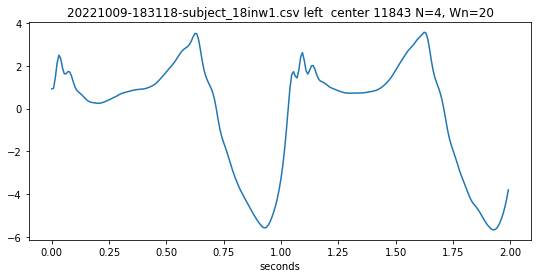

In [ ]:
N = 4
Wn = 20
df = load_data(file, low_pass = True, N=N, Wn=Wn)
points = df[LEFT_AVY_HEADER].values[center-1*FREQUENCY:center+1*FREQUENCY]
t = np.array([x for x in range(len(points))])/FREQUENCY
plt.plot( t, points)
plt.title(file+" "+"left "+" center " + str(center)+" N="+str(N)+", Wn="+str(Wn) )
plt.xlabel("seconds")
fig = plt.gcf()
fig.set_size_inches(9,4)

# Detect Gate Crossings

In [31]:
def find_lowest_valley(signal):
  '''finds the min peak in a signal.
  returns the x,y values from that signal where the min peak is'''
  inv_signal = -1*signal
  peak_indices = find_peaks(inv_signal)[0]
  edge_start = 3
  edge_end = len(signal)-edge_start -1
  peak_indices = [x for x in peak_indices if (edge_start < x < edge_end)]
  peak_values = [signal[x] for x in peak_indices]
  min_index =peak_values.index(min(peak_values))
  return peak_indices[min_index],peak_values[min_index]

def find_swing_stance_index(signal, min_percent=35):
  '''finds the peak right before the valley of the angular velocity y 
  data stream.
  input: signal from a single gate
  returns: index and value'''
  min_index = int(min_percent*len(signal)/100)
  #check_signal_dtype(signal)
  max_index, valley_value = find_lowest_valley(signal)
  peak_indices = find_peaks(signal)[0]
  possible_stance_change_index = []
  edge_start = 3  
  edge_end = len(signal)-edge_start -1
  for x in peak_indices:
    if (edge_end > x > edge_start) and (max_index > x > min_index):
      possible_stance_change_index.append(x)
  stance_change_index =  possible_stance_change_index[-1]
  stance_change_value = signal[stance_change_index]
  return stance_change_index, stance_change_value

def max_peak(signal):
  '''finds the max peak in a signal.
  returns the x,y values from that signal where the max peak is'''
  peak_indices = find_peaks(signal)[0]
  edge_start = 3
  edge_end = len(signal)-edge_start -1
  peak_indices = [x for x in peak_indices if (edge_start < x < edge_end)]
  peak_values = [signal[x] for x in peak_indices]
  max_index =peak_values.index(max(peak_values))
  return peak_indices[max_index],peak_values[max_index]

##  Context

In the graphs below, I have plotted the gate crossings as detected. A cycle is defined as the data between two gate crossings. A gate crossing is defined not by crossing the gate crossing global value. gate crossigns are highlighted with a red marker in the 3 cycle graphs. Index in this data is not equal to that in the excel file because the 5s that were removed. The outdoor data is significantly messier than the indoor.


In [32]:
def extract_gate_crossings(df: pd.core.frame.DataFrame, header:str, gate_crossing: float = -0.6) -> List[int]:
  '''input
  gate_crossing: set the zero crossing below zero to avoid false positives
  returns: zero_crossings: a list of all the indices when a value in df crosses from below gate_crossing to above it
  '''
  ##if the scale of the data is dramatically off, then the gate_crossing will likely have to be re-worked
  #value_range = df[header].max()-df[header].min()
  #if (value_range<9) or (value_range>15) or df[header].min()>-5:
  #  print("value range:", value_range)
  #  print("min value:", df[header].min())
  #  print("expected value range between 12 and 15 based on the gate crossing threshold set")
  ##storing the indices, not the row labels, of where in the df the zero crossing exists.
  zero_crossings = []
  for i, x in enumerate(df[header].to_list()):
    if i < df.shape[0]-1:
      #before = df[header].iloc[i]
      #after = df[header].iloc[i+1]
      ##zero crossing detected
      if df[header].iloc[i-2:i].mean() < gate_crossing and df[header].iloc[i:i+2].mean() > gate_crossing:
        zero_crossings.append(i)
  return zero_crossings


In [33]:
def pair_gate_ends(zero_crossings: List[int], sensor: str = None, filename: str=None, gate_length_bounds: dict =None ) -> List[Tuple[int]]:
  if gate_length_bounds:
    min_gate_length = gate_length_bounds[filename][sensor][0]
    max_gate_length = gate_length_bounds[filename][sensor][1]
  zero_pairs = []
  save= True
  for i in range(len(zero_crossings)-1):
    if not gate_length_bounds:
      save = True
    else:
      gate_length = zero_crossings[i+1]- zero_crossings[i]
      if min_gate_length < gate_length < max_gate_length:
        save = True
      else:
        save = False
    if save:
      zero_pairs.append((zero_crossings[i], zero_crossings[i+1]))
  return zero_pairs

In [34]:
def check_shape_zero_crossings(zero_crossings, avy_data):
  '''checks that there is a valley at all, and that there exists a 
  peak to the left of the valley and the right of 35% of the gate data points'''
  good_crossings = []
  for start, end in zero_crossings:
    try:
      find_swing_stance_index(avy_data[start:end])
      good_crossings.append((start,end))
    except ValueError:
      pass
    except IndexError:
      pass
  return good_crossings

In [35]:
def calc_all_gate_crossings(data_lookup: dict, gate_crossing: float = GATE_CROSSING, gate_length_bounds: dict =None):
  '''detects gate crossings for each leg for every file. 
  creates a lookup dict that allows for looking up gate values given a filename and leg
  saves zero crossings as tuples, not as a list, this way the tuples can be 
  filtered based on min,max gate lengths
  '''
  zero_crossing_lookup = {}
  for filename in metadata['filename'].to_list():
    df_1 = data_lookup[filename]
    ##zero crossings are lists here
    zero_crossings_right = extract_gate_crossings(df_1,RIGHT_AVY_HEADER, gate_crossing= gate_crossing)
    zero_crossings_left = extract_gate_crossings(df_1,LEFT_AVY_HEADER, gate_crossing= gate_crossing)
    ##conver zero crossings to tuples
    zero_crossings_right = pair_gate_ends(zero_crossings_right, sensor = RIGHT_AVY_HEADER,filename = filename, gate_length_bounds=gate_length_bounds)
    zero_crossings_left = pair_gate_ends(zero_crossings_left, sensor =LEFT_AVY_HEADER, filename = filename, gate_length_bounds=gate_length_bounds)
    ##check that the gates have the right shape
    zero_crossings_right = check_shape_zero_crossings(zero_crossings_right, df_1[RIGHT_AVY_HEADER].values)
    zero_crossings_left = check_shape_zero_crossings(zero_crossings_left, df_1[LEFT_AVY_HEADER].values)

    zero_crossing_lookup[filename]={'right':zero_crossings_right, 'left':zero_crossings_left}
  return zero_crossing_lookup


In [24]:
start = datetime.datetime.now()
zero_crossing_lookup=calc_all_gate_crossings(data_lookup)
print("took", (datetime.datetime.now()-start), "to run")

took 0:10:23.152148 to run


In [36]:
def graph_zero_crossings(zero_crossings: List[Tuple[int]], avy_data,filename:str, save_dir: str = 'gate_crossings', window: int = 50, graph_limit: int = 20, gate_max: int = None):
  '''graph_limit : number of graphs to make
  gate_max: if set, sets a max gate size. this allows you to create graphs of only small gates to look for sources of errors
  returns: None. saves and displays graphs
  '''
  max_gates_display = 3
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  assert(len(zero_crossings)>max_gates_display),"not enough zero crossings to plot"
  for i in range(3,len(zero_crossings)):
    if len(zero_crossings)>4:
      start = zero_crossings[i][0]
      end = zero_crossings[i][1]
      if (not gate_max) or ((end-start )< gate_max):
        fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(25,7))
        zero_cross_indices = [avy_data.index[zero_crossings[i][0]], avy_data.index[zero_crossings[i][1]]]
        zero_cross_values = [avy_data.iloc[zero_crossings[i][0]],avy_data.iloc[zero_crossings[i][1]] ]        
        ax[0].plot(avy_data.iloc[end-window:end+window])
        ax[0].set_title(label='around recent zero')
        ax[0].scatter([zero_cross_indices[1]],[zero_cross_values[1]]  , color='red')
        ax[1].plot(avy_data.iloc[start:end])
        ax[1].set_title(label='prev 1 cycle')   
        ax[1].scatter(zero_cross_indices,zero_cross_values  , color='red')
        ax[2].plot(avy_data.iloc[zero_crossings[i-max_gates_display][1]:end])
        ax[2].scatter(zero_cross_indices,zero_cross_values  , color='red')
        ax[2].set_title(label='prev 3 cycles')
        ax[2].scatter(zero_cross_indices,zero_cross_values  , color='red') 
        fig.suptitle("graph " + "{:,}".format(graph_limit) + ". "+filename+" inspecting row "+"{:,}".format(end) + ". gate size "+str(end-start))
        fig.savefig(os.path.join(save_dir,str(graph_limit)+'.png'))
        graph_limit -=1
        if graph_limit==0:
          break

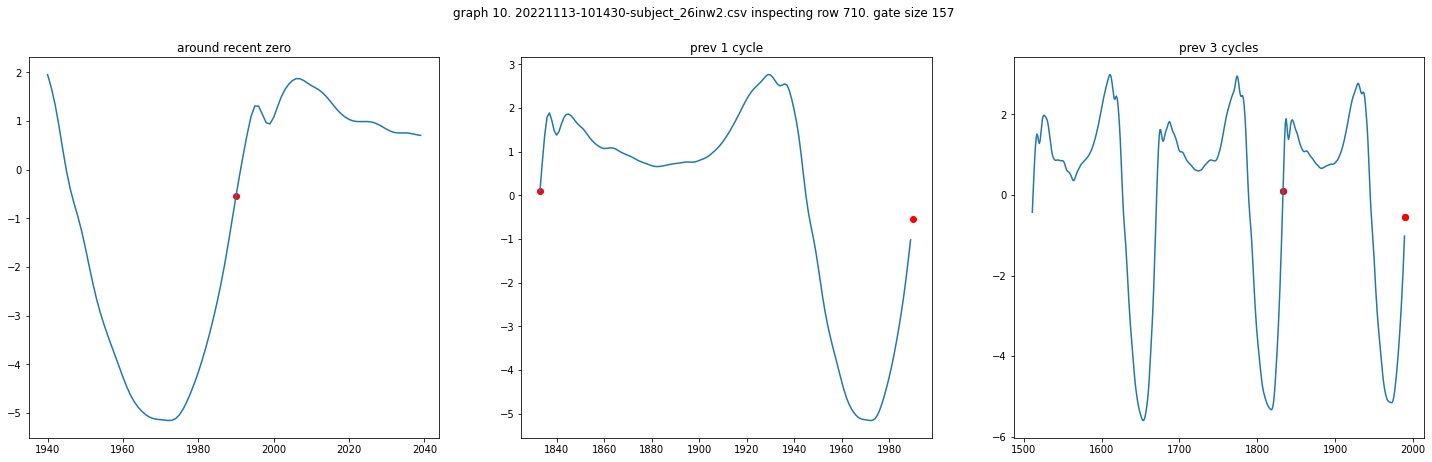

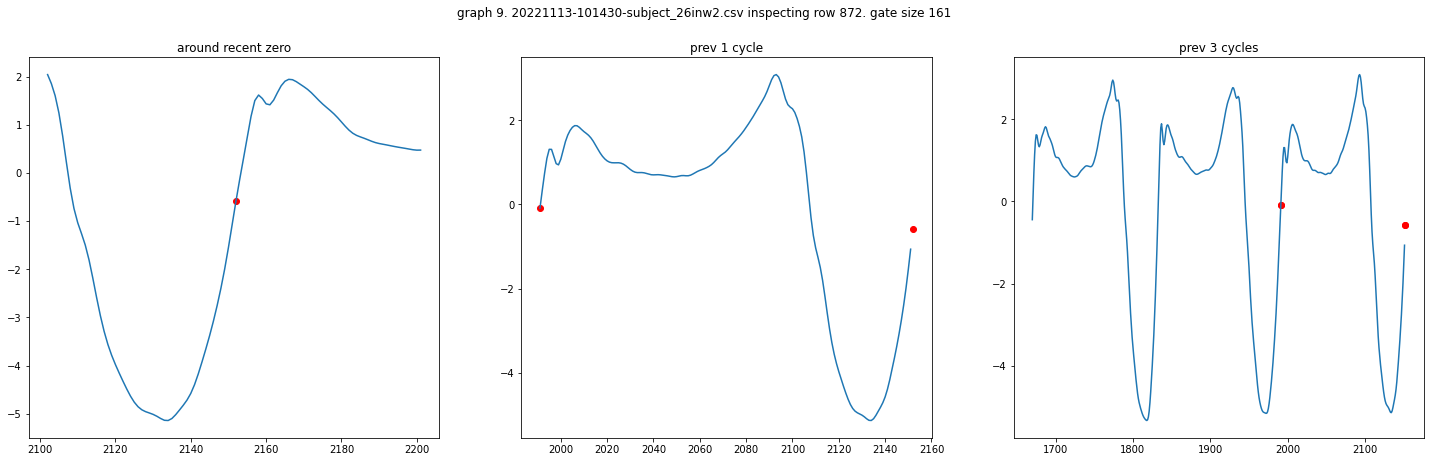

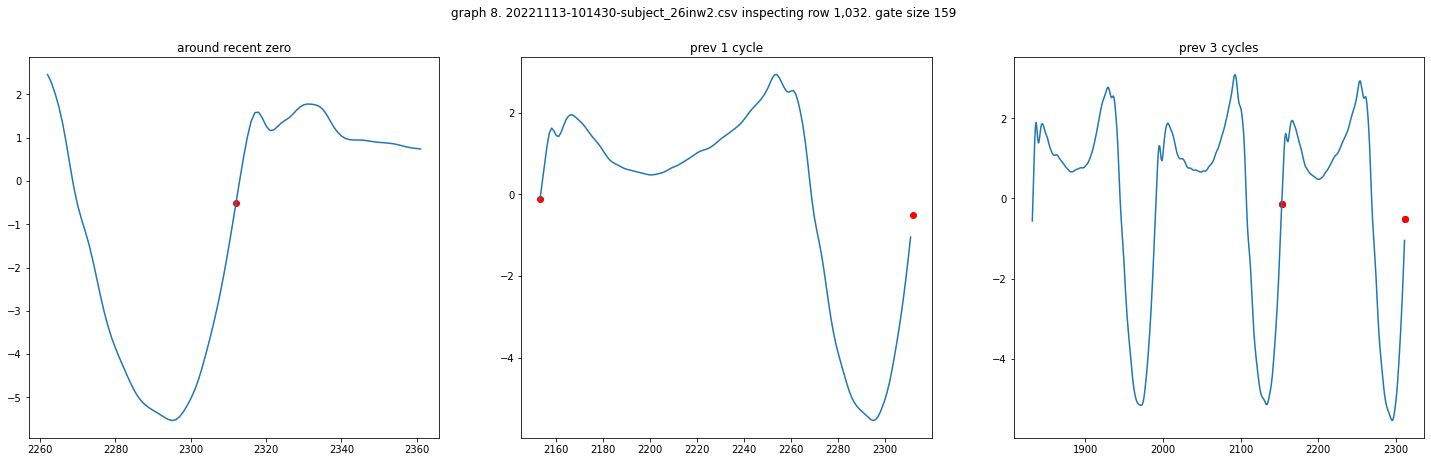

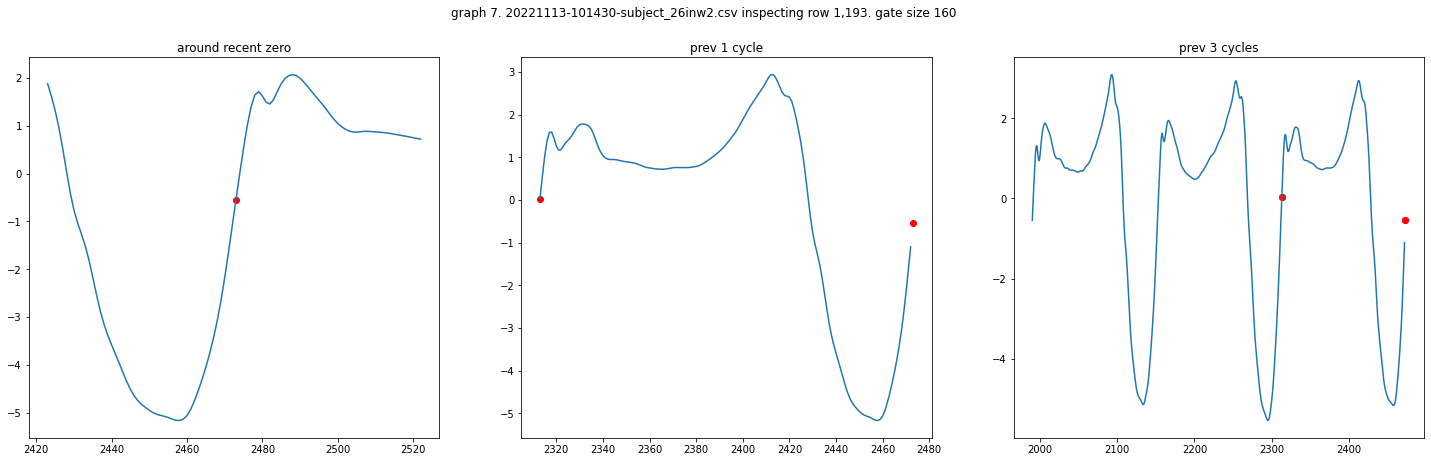

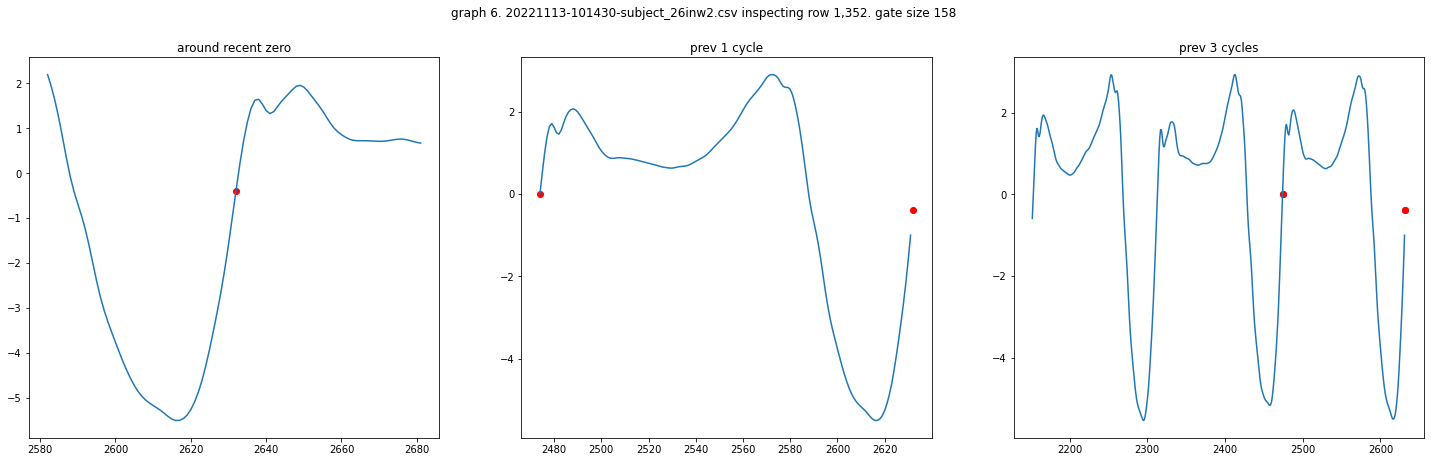

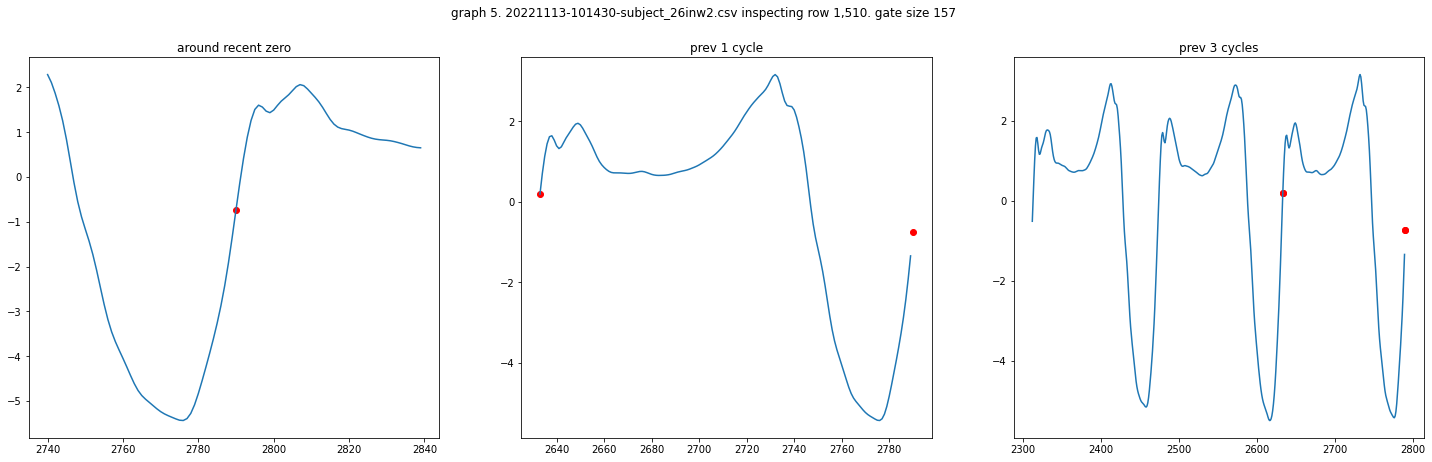

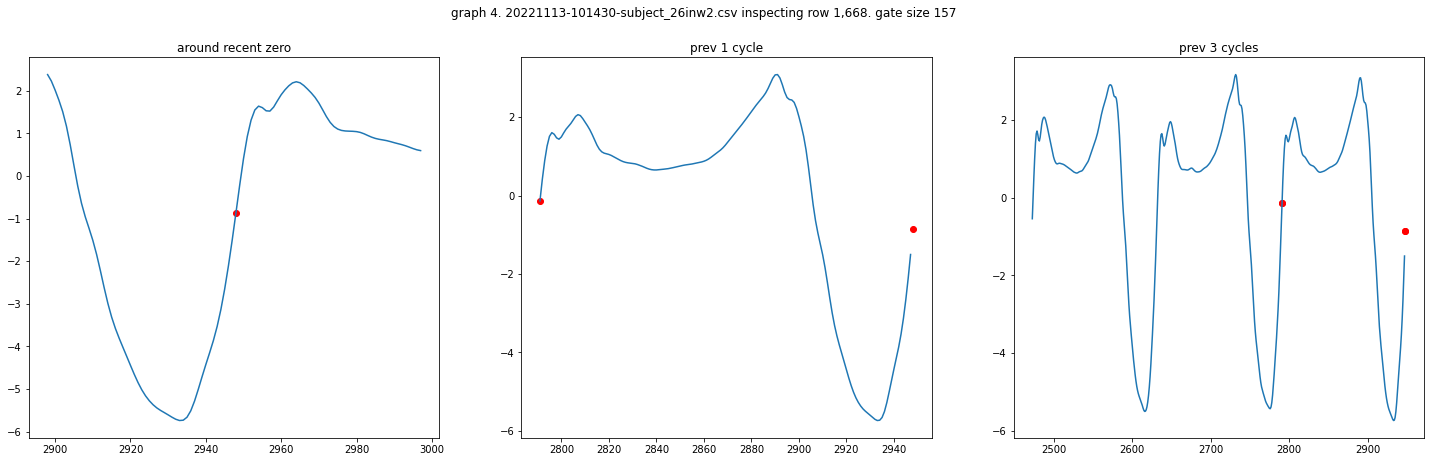

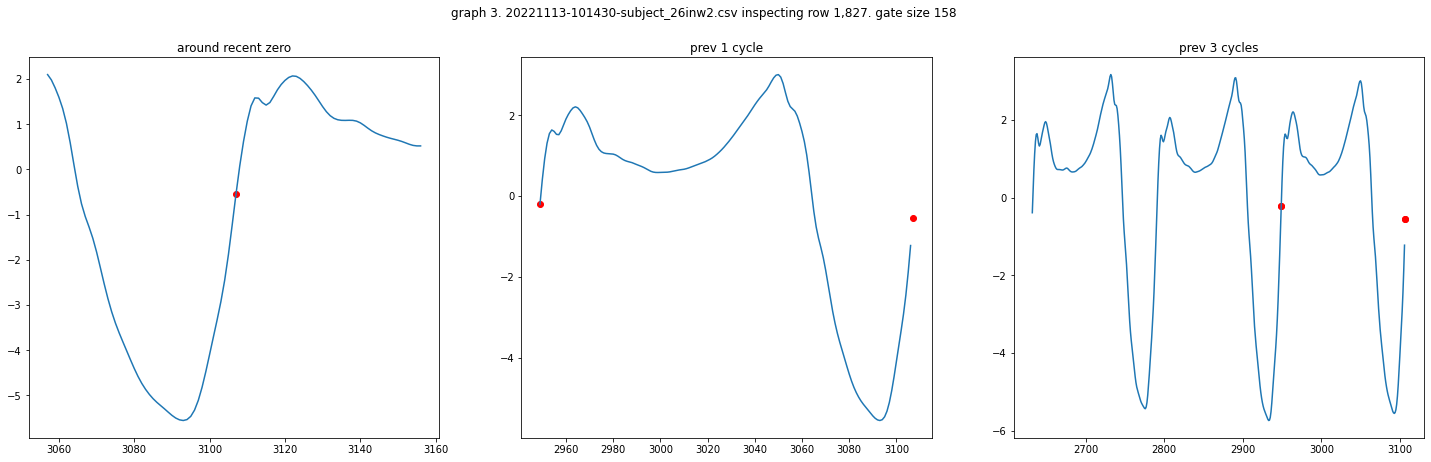

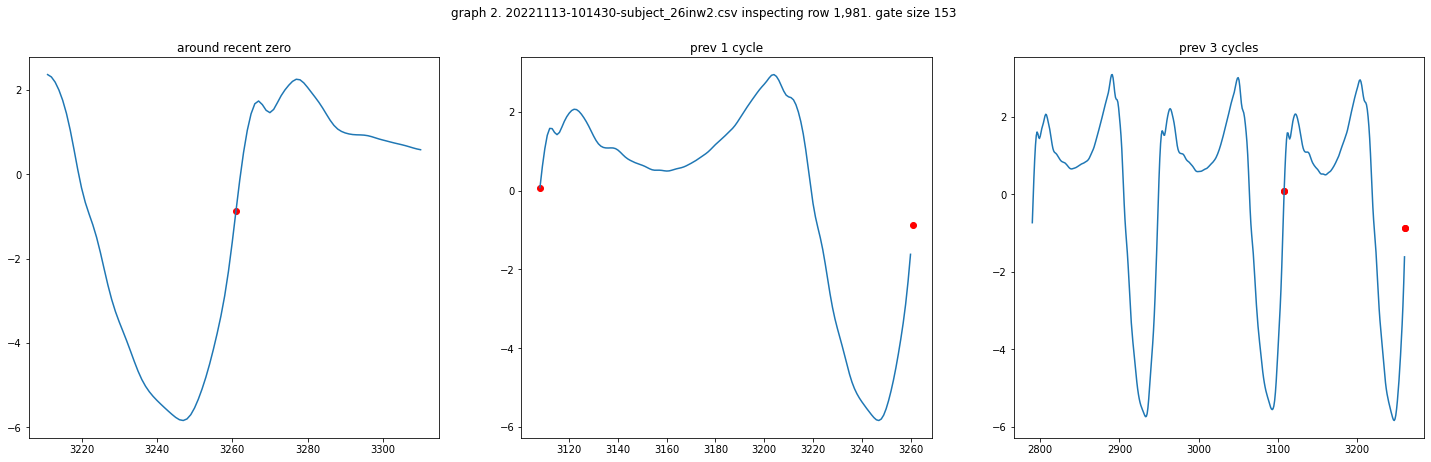

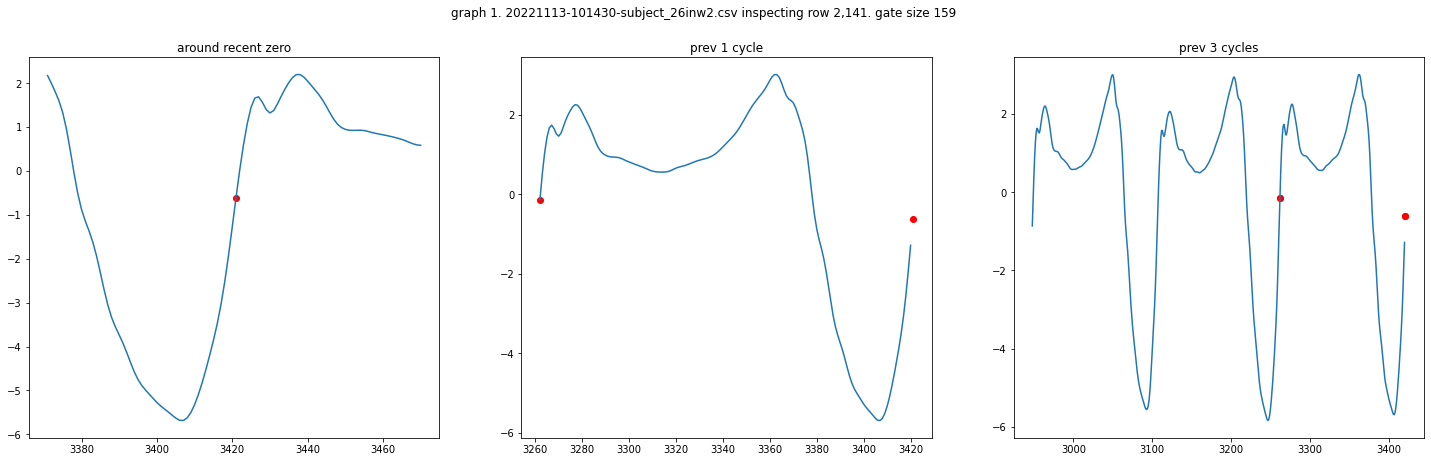

In [37]:
zero_crossings_right= zero_crossing_lookup[file][COLUMNS_TO_LEG[RIGHT_AVY_HEADER]]
graph_zero_crossings(zero_crossings_right,df[RIGHT_AVY_HEADER],filename=file, save_dir= os.path.join('Analysis','gate_crossings'), window= 50, graph_limit = 10)

# Analyze the size of the average gate



In [38]:
def avg_std_gate_lengths(zero_crossings: List[Tuple[int]]):
  points_p_gate = [x[1]-x[0] for x in zero_crossings]
  points_p_gate = np.array(points_p_gate)
  return  points_p_gate.mean() , points_p_gate.std(), points_p_gate.max(), points_p_gate.min()  

In [39]:
def hist_gate_lengths(zero_crossing: List[Tuple[int]]):
  avg, std , m, n = avg_std_gate_lengths(zero_crossings)
  print("mean:", round(avg,2), "std:",round(std,2), " max:", m, "min:", n )
  points_p_gate = [x[1]-x[0] for x in zero_crossings]
  plt.hist(points_p_gate)
  _ = plt.title("Histogram of Gate Size")
  plt.xlabel("size of gate (data points)")
  plt.ylabel("# of gates detected")

## Basic Stats of Gate Lengths

calc avg, std, max, min of sensors, with and then with a gate crossing at -0.6 and then at 0

Take notice in the table below that the max and min gate sizes are quite a bit larger than the avg. This being true, they are rare outliers as the low std shows.

In [40]:
save_dir_gate_lengths = os.path.join("Analysis", "stats_of_gate_lengths")
if not os.path.exists(save_dir_gate_lengths):
  os.mkdir(save_dir_gate_lengths)

In [41]:
def find_gate_crossing_threshold(data_lookup, metadata: pd.core.frame.DataFrame, save_dir_gate_lengths:str):
  '''to find out how the gate crossing threshold impacts the stats of the gate
     lengths, calculate the average gate lengths with varying gate_crossing values'''
  stats_data = []
  for gate_crossing in [0,-0.3, -0.6, -0.9, -1.2]:
    zero_crossing_lookup=calc_all_gate_crossings(data_lookup, gate_crossing = gate_crossing)
    for sensor_cols in [RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:
      for i, inout in enumerate(['indoors', 'outdoors']):
        all_gate_lengths = []
        for x in metadata[metadata['inout']==inout].groupby(by=['subjectID', 'pace']):
          df_trials=x[1]
          for filename in df_trials['filename'].values:
            zero_crossings = zero_crossing_lookup[filename][COLUMNS_TO_LEG[sensor_cols]]
            points_p_gate = [x[1]-x[0] for x in zero_crossings]
            all_gate_lengths.extend(points_p_gate)
        all_gate_lengths = np.array(all_gate_lengths)
        stats_data.append([sensor_cols, COLUMNS_TO_AREA[sensor_cols], inout, all_gate_lengths.mean(), all_gate_lengths.std(), all_gate_lengths.max(), all_gate_lengths.min(), gate_crossing])
  stats_df = pd.DataFrame(stats_data, columns=['sensor_name', 'area', 'inout', 'avg gate length (data points)', 'std', 'max', 'min', 'vertical_gate_crossing'])
  stats_df.to_csv(os.path.join(save_dir_gate_lengths, "gate_lengths_per_vertical_crossing.csv"))
  return stats_df

In [42]:
start = datetime.datetime.now()
stats_df= find_gate_crossing_threshold(data_lookup, metadata, save_dir_gate_lengths)
time_passed = (datetime.datetime.now()-start)
print("took",time_passed, "s to run")

AttributeError: ignored

In [44]:
def graphing_gate_crossing_thresholds(stats_df: pd.core.frame.DataFrame, save_dir_gate_lengths: str):
  for column_to_graph in [RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    for i, inout in enumerate(['indoors', 'outdoors']):
      wherec = ((stats_df['inout']==inout) & (stats_df['sensor_name']==column_to_graph))
      avg = stats_df[wherec]['avg gate length (data points)']
      std =  stats_df[wherec]['std']
      mx =  stats_df[wherec]['max']
      x_gates =stats_df[wherec]['vertical_gate_crossing']
      #fig, ax = plt.subplots()
      ax[i].plot(x_gates ,avg, color='black')
      ax[i].fill_between(x_gates, avg-std, avg+std, alpha=0.4, color='gray')
      ax[i].set_xlabel("gate crossing threshold")
      ax[i].set_ylabel("gate size (data points)")
      title = column_to_graph+ ' '+COLUMNS_TO_AREA[column_to_graph]
      _= ax[i].set_title( title+ ' ' + inout)     
      fig.savefig(os.path.join(save_dir_gate_lengths,title.replace(os.path.sep, '-')+'.png'))

took 1.87025 to run


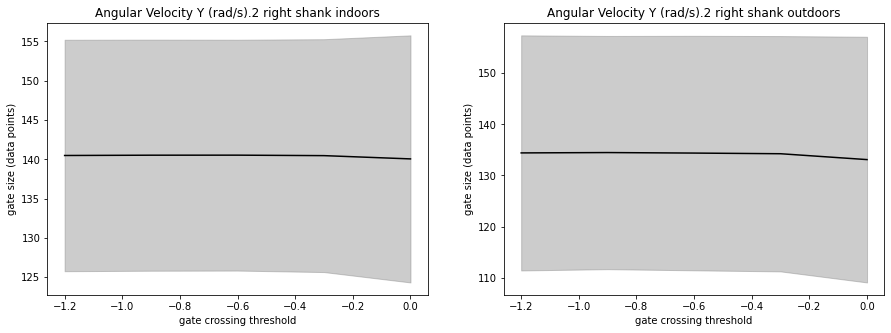

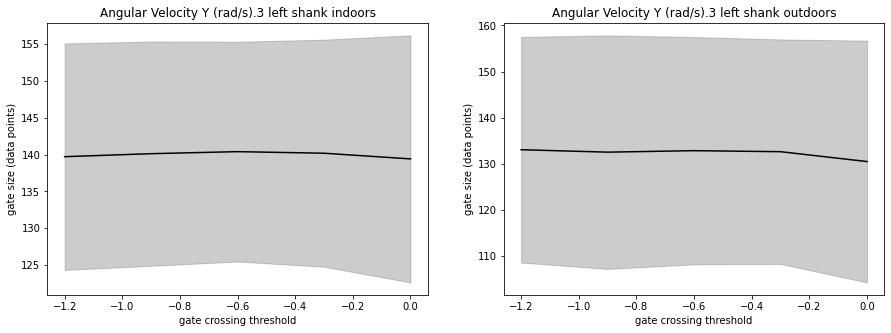

In [45]:
start = datetime.datetime.now()
graphing_gate_crossing_thresholds(stats_df, save_dir_gate_lengths)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")


In [ ]:
zero_crossing_lookup =calc_all_gate_crossings(data_lookup, GATE_CROSSING)


## Stats of Gate Lengths by File

In [50]:
def stats_gate_lengths_by_file(df_cols: List[str], save_dir_gate_lengths: str, fname_gate_length_file: str = "per_file", MAX_STD: float = 2, zero_crossing_lookup: dict =None):
  '''for each of the two main sensors, create a csv with the gate length 
    stats for each file, also track the thresholds for each file of what
    defines an outlier'''
  filter_to_gate_thresh = {}
  for filename in metadata['filename']:
    filter_to_gate_thresh[filename] = {}
  print("gate crossing used", GATE_CROSSING)
  if not zero_crossing_lookup:
    zero_crossing_lookup=calc_all_gate_crossings(gate_crossing = GATE_CROSSING)
  for sensor_cols in [RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:
    df_per_file = pd.DataFrame([], columns =df_cols )
    per_filename =fname_gate_length_file+'_'+ sensor_cols.replace(os.path.sep, '-')+".csv"  
    for i, inout in enumerate(['indoors', 'outdoors']):
      for x in metadata[metadata['inout']==inout].groupby(by=['subjectID', 'pace']):
        df_trials=x[1]
        for filename in df_trials['filename'].values:
          subjectID, inout, pace, trial, timestamp =extract_trial_data(filename)
          zero_crossings = zero_crossing_lookup[filename][COLUMNS_TO_LEG[sensor_cols]]
          avg, std , ppgmax, ppgmin = avg_std_gate_lengths(zero_crossings)
          row = [sensor_cols,COLUMNS_TO_AREA[sensor_cols], inout, filename, trial, subjectID, avg,std,ppgmax, ppgmin,data_lookup[filename].shape[0], GATE_CROSSING]
          filter_to_gate_thresh[filename][sensor_cols] = (avg-MAX_STD*std, avg+MAX_STD*std)
          df_per_file = pd.concat([df_per_file, pd.DataFrame([row], columns=df_cols)])
    df_per_file.sort_values('std',inplace=True, ignore_index=True )
    df_per_file.to_csv(os.path.join(save_dir_gate_lengths,per_filename), index=False)
  print("saving file", fname_gate_length_file, " with gate length stats per file")
  return df_per_file, filter_to_gate_thresh

In [51]:
start = datetime.datetime.now()
df_gate_stats_cols = ['sensor','area', 'in-out', 'filename','trial', 'subjectID' ,'avg gate length (data points)', 'std', 'max', 'min', 'data points per file', 'vertical_gate_crossing' ]
df_per_file, filter_to_gate_thresh = stats_gate_lengths_by_file(df_gate_stats_cols, save_dir_gate_lengths, MAX_STD= 2, zero_crossing_lookup=zero_crossing_lookup)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

gate crossing used -0.3
saving file per_file  with gate length stats per file
took 0.468406 to run


In [52]:
def plot_gate_lengths_p_subject(filename,save_dir_gate_lengths):
  df_gate_lengths = pd.read_csv(os.path.join(save_dir_gate_lengths,filename))
  print("stats of gate lengths (data Points)")
  print(df_gate_lengths['avg gate length (data points)'].describe())
  print("\nstd of gate lengths (data Points)")
  print(df_gate_lengths['std'].describe())
  df_gate_lengths['std/avg'] =df_gate_lengths.apply(lambda x: x['std']/x['avg gate length (data points)'], axis=1) 
  print("\nstats of std/avg")
  percentiles = df_gate_lengths['std/avg'].describe()
  print(percentiles)
  fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
  ax[0].scatter(df_gate_lengths['subjectID'].values,df_gate_lengths['std/avg'].values )
  _ = ax[0].set_xlabel("SubjectID")
  _ = ax[0].set_ylabel("std/avg")
  _ = ax[0].set_title("Variation in gate lengths per subject: "+df_gate_lengths['area'].iloc[0]+ " "+df_gate_lengths['sensor'].iloc[0])
  outliers_df = df_gate_lengths[df_gate_lengths['std/avg']>percentiles['75%']].copy()
  print("number of outliers defined by 75 percentile:", outliers_df.shape[0])
  print("outliers by indoors/outdoors")
  ct_indoors = outliers_df[outliers_df['in-out']=='indoors'].shape[0]
  print("\tindoors", ct_indoors, "{}%".format(round(100*ct_indoors/outliers_df.shape[0]),2))
  print("\toutdoors", outliers_df.shape[0]-ct_indoors, "{}%".format(round(100*(outliers_df.shape[0]-ct_indoors)/outliers_df.shape[0]),2))
  outlier_p_subject = Counter(outliers_df['subjectID'].values)
  osub = list(outlier_p_subject.keys())
  oct = [outlier_p_subject[x] for x in osub]
  ax[1].bar(osub,oct )
  _ = ax[1].set_xlabel("SubjectID")
  _ = ax[1].set_ylabel("count outlier files")
  _ = ax[1].set_title("75 Percentile outliers")
  fig.savefig(os.path.join(save_dir_gate_lengths,"std-avg_outlier_graph_"+df_gate_lengths['area'].iloc[0]+".png"))
  return df_gate_lengths

In [53]:
df_gate_lengths_r = plot_gate_lengths_p_subject("per_file_Angular Velocity Y (rad-s).2.csv",save_dir_gate_lengths)

stats of gate lengths (data Points)
count     90.000000
mean     139.121195
std       16.548757
min       61.814286
25%      132.399832
50%      139.057294
75%      150.600746
max      169.184874
Name: avg gate length (data points), dtype: float64

std of gate lengths (data Points)
count    90.000000
mean      7.017537
std       6.418678
min       1.794207
25%       3.053489
50%       4.889710
75%       7.759901
max      33.008162
Name: std, dtype: float64

stats of std/avg
count    90.000000
mean      0.056161
std       0.069173
min       0.011764
25%       0.021607
50%       0.034792
75%       0.057879
max       0.467113
Name: std/avg, dtype: float64
number of outliers defined by 75 percentile: 23
outliers by indoors/outdoors
	indoors 10 43%
	outdoors 13 57%


stats of gate lengths (data Points)
count     90.000000
mean     138.254409
std       17.248390
min       62.018868
25%      131.558226
50%      138.234300
75%      150.560755
max      169.175000
Name: avg gate length (data points), dtype: float64

std of gate lengths (data Points)
count    90.000000
mean      8.076573
std       7.518187
min       1.741247
25%       3.350422
50%       5.065542
75%       8.804166
max      36.487528
Name: std, dtype: float64

stats of std/avg
count    90.000000
mean      0.065087
std       0.077079
min       0.011418
25%       0.023263
50%       0.035724
75%       0.069413
max       0.452360
Name: std/avg, dtype: float64
number of outliers defined by 75 percentile: 23
outliers by indoors/outdoors
	indoors 7 30%
	outdoors 16 70%


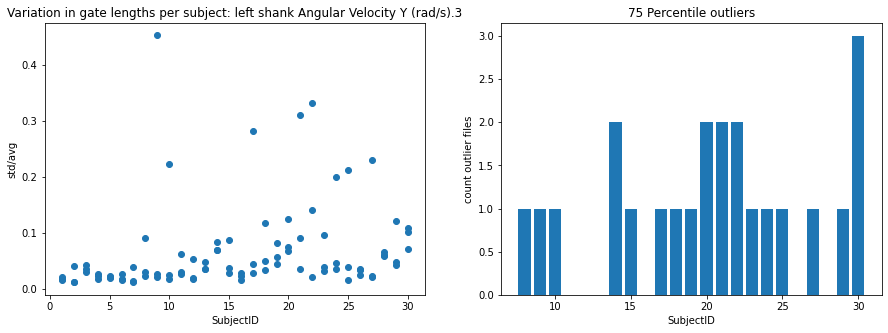

In [54]:
df_gate_lengths_l = plot_gate_lengths_p_subject("per_file_Angular Velocity Y (rad-s).3.csv",save_dir_gate_lengths)

## Filter Outliers

filter out gates that are more than 2 std away from avg

In [55]:
start = datetime.datetime.now()

##re-calculate the zero crossings with filter applied
zero_crossing_lookup=calc_all_gate_crossings(data_lookup, gate_crossing = GATE_CROSSING, gate_length_bounds= filter_to_gate_thresh)
##re-calculate the stats of the gate lengths now that the filter has been applied
df_gate_stats_cols = ['sensor','area', 'in-out', 'filename','trial', 'subjectID' ,'avg gate length (data points)', 'std', 'max', 'min', 'data points per file', 'vertical_gate_crossing' ]
df_per_file_filtered, _ = stats_gate_lengths_by_file(df_gate_stats_cols, save_dir_gate_lengths,fname_gate_length_file = "per_file_2std_filtered_outliers" , MAX_STD= 2, zero_crossing_lookup=zero_crossing_lookup)
print("took", (datetime.datetime.now()-start), "to run")


gate crossing used -0.3
saving file per_file_2std_filtered_outliers  with gate length stats per file
took 527.816519 to run


# Start Combining Data

## Combine Gate Data from Single File

In [56]:
def grab_normalized_gate(df: pd.core.frame.DataFrame, zero_crossings: List[Tuple[int]], gate_ind:int , header:str):
  '''grabs the gate at the index given and normalizes the data points to 100'''
  start =zero_crossings[gate_ind][0]
  end=zero_crossings[gate_ind][1]
  raw_series = df[header].iloc[start:end]
  raw_values = raw_series.values
  raw_index = list(raw_series.index)
  interp = interp1d(raw_index, raw_values)
  sampled = interp(np.linspace(min(raw_index), max(raw_index),num=100))
  return raw_values, sampled

In [57]:
def calc_avg_std_gates(df: pd.core.frame.DataFrame, zero_crossings: List[int] , header:str):
  '''aggregates all the sampled gates together for one column/sensor after
  normalizing the length of the gate to 100 data points'''
  ct_gates = len(zero_crossings)-1
  all_gates = np.zeros((ct_gates,100))
  for i in range(ct_gates):
    _, all_gates[i] = grab_normalized_gate(df,zero_crossings, i, header)
  avg = all_gates.mean(axis=0)
  std = all_gates.std(axis=0)
  return avg, std , all_gates

In [58]:
zero_crossings_right= zero_crossing_lookup[file][COLUMNS_TO_LEG[RIGHT_AVY_HEADER]]
zero_crossings_left= zero_crossing_lookup[file][COLUMNS_TO_LEG[LEFT_AVY_HEADER]]

In [59]:
print("number gates - right leg", len(zero_crossings_right)-1)
print("number gates - left leg", len(zero_crossings_left)-1)

number gates - right leg 124
number gates - left leg 123


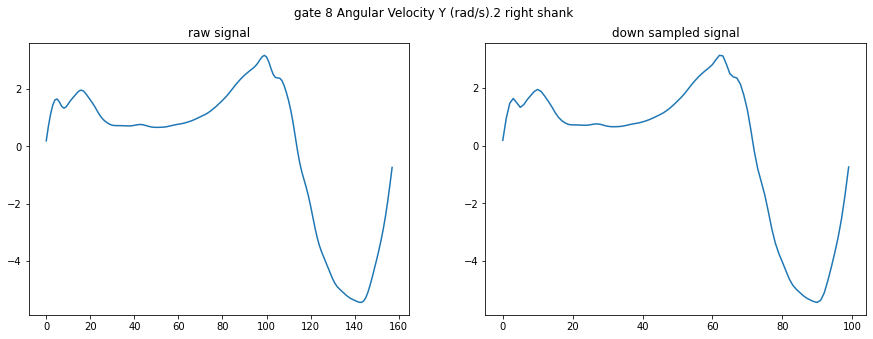

In [60]:
##graph a gate at random
##graph the raw signal and the signal normalized to 100 points via upsampling or downsampling

##tried using resample, but it was more prone to introducing noise and didn't work with upsampling
##interpolation works with both upsampling and downsampling
gate_ind = random.randint(0,len(zero_crossings_right)-2)
raw_values, sampled = grab_normalized_gate(df,zero_crossings_right, gate_ind, RIGHT_AVY_HEADER)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax[0].plot(raw_values)
ax[0].set_title("raw signal")
ax[1].plot(sampled)
ax[1].set_title("down sampled signal")
_=fig.suptitle("gate "+str(gate_ind)+ ' '+RIGHT_AVY_HEADER+ ' '+COLUMNS_TO_AREA[RIGHT_AVY_HEADER])

In [61]:
def label_axis(column_to_graph, ax):
  if 'Velocity' in column_to_graph:
    ax.set_ylabel("rad/s")
  elif 'Acceleration' in column_to_graph:
    ax.set_ylabel("m/s^2")
  else:
    print(column_to_graph)
  ax.set_xlabel('normalized time')


In [62]:
def grab_peak_valley(signal):
  peak_index,peak_value = find_swing_stance_index(signal)
  valley_index,valley_value = find_lowest_valley(signal)
  pv_i = [peak_index, valley_index]
  pv_v = [peak_value, valley_value]
  return pv_i, pv_v

In [63]:
def select_random_df(metadata,data_lookup ):
  subject_id_list = metadata['subjectID'].unique()
  subjectID = subject_id_list[random.randint(0,len(subject_id_list)-1)] 
  filenames = metadata[metadata.subjectID==subjectID]['filename'].values
  filename = filenames[np.random.randint(low=0, high=(len(filenames)-1))]
  return data_lookup[filename]  , filename

In [64]:
def plot_avy_peak_singlefile(subjectID: int, metadata, data_lookup, zero_crossing_lookup):
  '''plot the avg across all gates for the primary data streams 
  on the left and right foot'''
  df , filename= select_random_df(metadata,data_lookup )
  zero_crossings_left=zero_crossing_lookup[filename]['left']
  zero_crossings_right= zero_crossing_lookup[filename]['right']
  avg_left, std_left, all_gates_left  = calc_avg_std_gates(df, zero_crossings_left,LEFT_AVY_HEADER)
  avg_right, std_right, all_gates_right  = calc_avg_std_gates(df, zero_crossings_right, RIGHT_AVY_HEADER)
  print("shape of all gates right", all_gates_right.shape)
  print("shape of all gates left", all_gates_left.shape)
  print("plotted in red are the max peak and min valley")
  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
  ax[0].plot(avg_left, color='black')
  ax[0].fill_between(np.arange(0,100), avg_left-std_left, avg_left+std_left, alpha=0.4, color='gray')
  ax[0].scatter(*grab_peak_valley(avg_left), color='red', s=100, alpha=1)
  ax[0].set_title(LEFT_AVY_HEADER+' '+COLUMNS_TO_AREA[LEFT_AVY_HEADER])
  label_axis(LEFT_AVY_HEADER, ax[0])
  ax[1].plot(avg_right, color='black')
  ax[1].fill_between(np.arange(0,100), avg_right-std_right, avg_right+std_right, alpha=0.4, color='gray')
  ax[1].scatter(*grab_peak_valley(avg_right), color='red', s=100, alpha=1)
  ax[1].set_title(RIGHT_AVY_HEADER+ ' '+COLUMNS_TO_AREA[RIGHT_AVY_HEADER])
  label_axis(RIGHT_AVY_HEADER, ax[1])
  _ = fig.suptitle("average gate plots for file "+file)

In [65]:
plot_avy_peak_singlefile(subjectID, metadata, data_lookup, zero_crossing_lookup)

shape of all gates right (136, 100)
shape of all gates left (142, 100)
plotted in red are the max peak and min valley


In [66]:
##exploring other data streams with the gates defined above
avg_right, std_right, all_gates_right = calc_avg_std_gates(df, zero_crossings_right,COLUMNS_TO_GRAPH[0])
avg_left, std_left, all_gates_left  = calc_avg_std_gates(df, zero_crossings_left,COLUMNS_TO_GRAPH[2])
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax[0].plot(avg_left, color='black')
ax[0].fill_between(np.arange(0,100), avg_left-std_left, avg_left+std_left, alpha=0.4, color='gray')
ax[0].set_title(COLUMNS_TO_GRAPH[2]+ ' '+COLUMNS_TO_AREA[COLUMNS_TO_GRAPH[2] ])
label_axis(COLUMNS_TO_GRAPH[2], ax[0])
ax[1].plot(avg_right, color='black')
ax[1].fill_between(np.arange(0,100), avg_right-std_right, avg_right+std_right, alpha=0.4, color='gray')
ax[1].set_title(COLUMNS_TO_GRAPH[0]  +' '+COLUMNS_TO_AREA[COLUMNS_TO_GRAPH[0] ])
label_axis(COLUMNS_TO_GRAPH[0], ax[1])

_ = fig.suptitle("average gate plots for file "+file)


## Combine Gate Data from single Subject - Across Trials


In [139]:
metadata

filename  subjectID     inout    pace  trial  \
0   20220817-105702-subject_01inw1.csv          1   indoors  normal      1   
1   20220823-140901-subject_03onw1.csv          3  outdoors  normal      1   
2   20220825-103542-subject_05onw1.csv          5  outdoors  normal      1   
3   20220824-111447-subject_04inw2.csv          4   indoors  normal      2   
4   20220820-202012-subject_02onw1.csv          2  outdoors  normal      1   
..                                 ...        ...       ...     ...    ...   
85  20221113-114232-subject_27onw1.csv         27  outdoors  normal      1   
86  20221119-103754-subject_30onw1.csv         30  outdoors  normal      1   
87  20221119-100727-subject_30inw2.csv         30   indoors  normal      2   
88  20221119-100257-subject_30inw1.csv         30   indoors  normal      1   
89  20221220-164624-subject_25onw1.csv         25  outdoors  normal      1   

    timestamp  
0  2022-08-17  
1  2022-08-23  
2  2022-08-25  
3  2022-08-24  
4  2022-08-20  
..        ...  
85 2022-11-13  
86 2022-11-19  
87 2022-11-19  
88 2022-11-19  
89 2022-12-20  

[90 rows x 6 columns]

In [145]:
##to combine different trials, filter on 'subjectID', 'pace', 'inout', 
##  if more than one row exists, concatenate the data from the rows
def aggregate_single_subject(data_lookup,metadata: pd.core.frame.DataFrame, zero_crossing_lookup: dict, column_to_graph:str, inout:str , subjectID: int, pace: str ='normal'):
  '''given one subject, pace, and inout. it combines all the data across all the files
  inout could be either [indoors, outdoors]'''
  where_cond = ((metadata['subjectID']==subjectID)&(metadata['inout']==inout)&(metadata['pace']==pace))
  records = metadata[where_cond]
  #print('analyzing file(s) ', records.values)
  if records.shape[0]==1:
    filename =records['filename'].iloc[0]
    df_1 = data_lookup[filename]
    zero_crossings = zero_crossing_lookup[filename][COLUMNS_TO_LEG[column_to_graph]]
    avg, std , all_gates = calc_avg_std_gates(df_1, zero_crossings, column_to_graph)
  elif records.shape[0]==2:
    df_1 = data_lookup[ records['filename'].iloc[0]]
    zero_crossings_1 = zero_crossing_lookup[records['filename'].iloc[0]][COLUMNS_TO_LEG[column_to_graph]]
    _, _ , all_gates_1 = calc_avg_std_gates(df_1, zero_crossings_1, column_to_graph)
    df_2 = data_lookup[records['filename'].iloc[1]]
    zero_crossings_2 =zero_crossing_lookup[records['filename'].iloc[1]][COLUMNS_TO_LEG[column_to_graph]]
    _, _ , all_gates_2 = calc_avg_std_gates(df_2, zero_crossings_2, column_to_graph)   
    all_gates = np.concatenate((all_gates_1,all_gates_2), axis=0 )
    #avg = all_gates.mean(axis=0)
    #std = all_gates.std(axis=0)     
  else:
    errstr = "\nsubject {} inout {} pace {}".format(subjectID, inout, pace)
    raise Exception("unexpected number of files "+ str(records)+errstr)   

  return all_gates

In [141]:
start = datetime.datetime.now()
print("randomly selects a subject and a column to graph")

inout ='outdoors'
subject_id_list = metadata['subjectID'].unique()
subjectID = subject_id_list[random.randint(0,len(subject_id_list)-1)]
column_to_graph = COLUMNS_TO_GRAPH[random.randint(0,len(COLUMNS_TO_GRAPH)-1)]
all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, column_to_graph, inout , subjectID, pace=PACE)
avg = all_gates.mean(axis=0)
std = all_gates.std(axis=0)
fig, ax = plt.subplots()
ax.plot(avg, color='black')
label_axis(column_to_graph, ax)

ax.fill_between(np.arange(0,100), avg-std, avg+std, alpha=0.4, color='gray')
_= ax.set_title("subject " + str(subjectID) + " " +column_to_graph+ ' '+COLUMNS_TO_AREA[column_to_graph] + ' ' + inout) 
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

randomly selects a subject and a column to graph
took 0.059457 to run


### Save Data For Each Subject-Sensor

For each sensor create a csv file. Each file with have n_subjects rows. Each row will be the averaged and normalized signal for that subject for that sensor.

<ipython-input-142-e6115d064fb2>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-142-e6115d064fb2>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-142-e6115d064fb2>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy

took 110.179406 to run


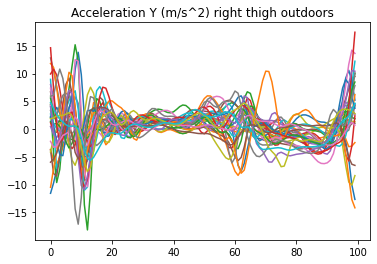

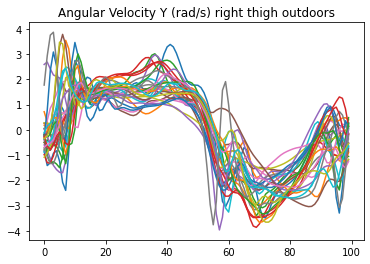

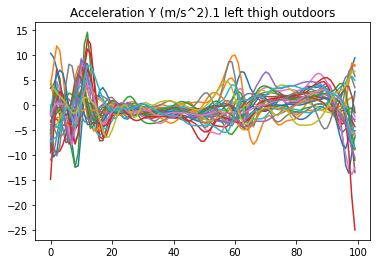

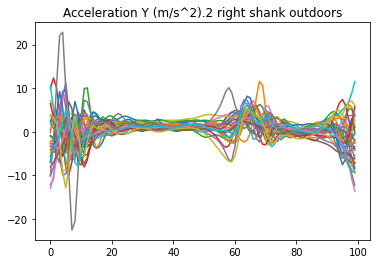

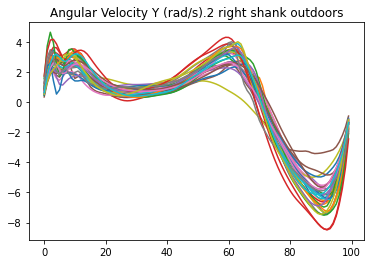

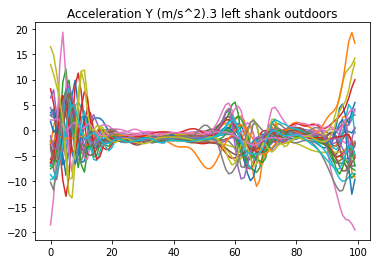

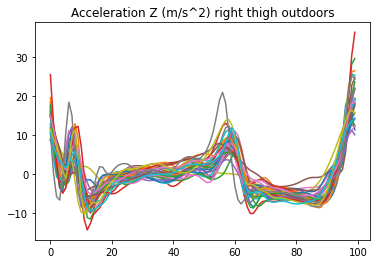

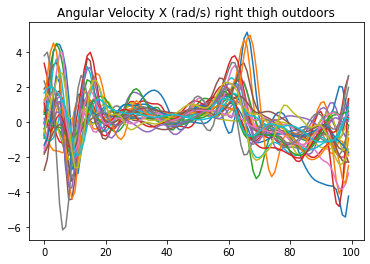

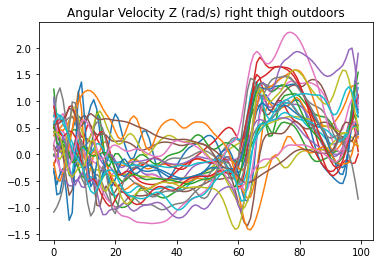

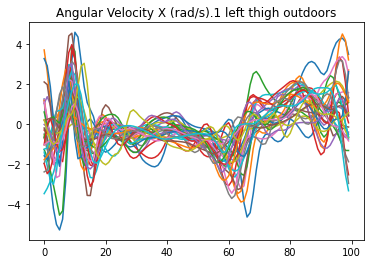

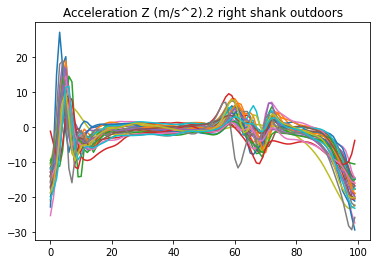

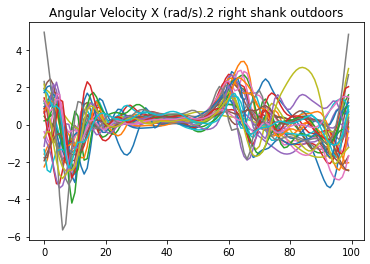

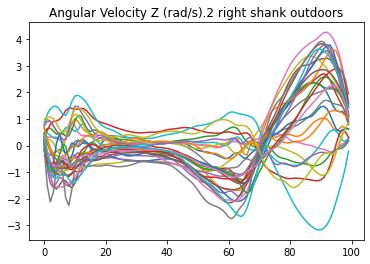

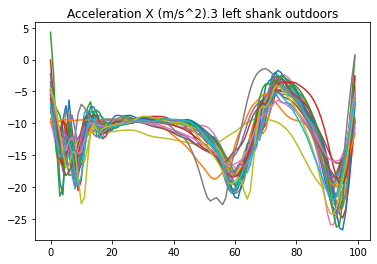

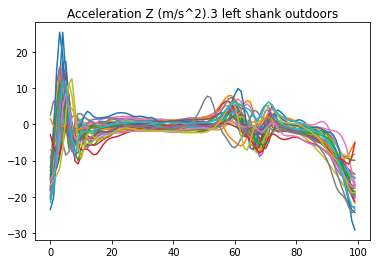

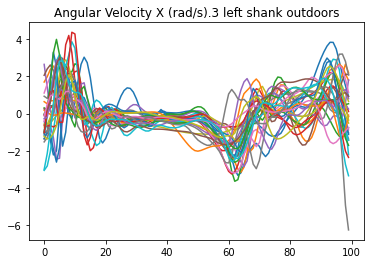

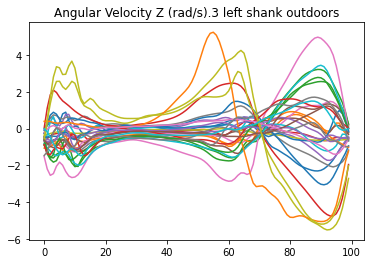

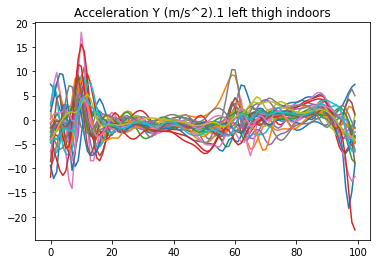

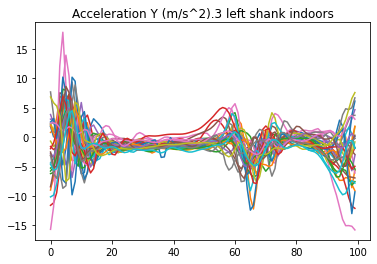

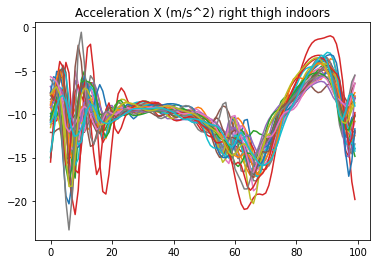

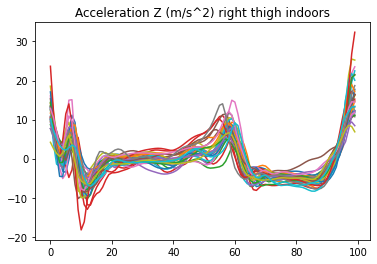

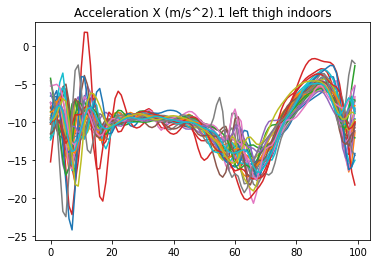

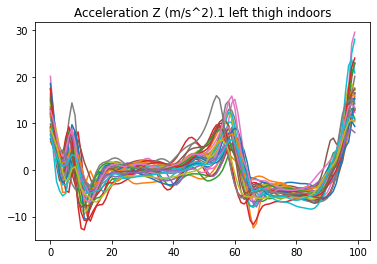

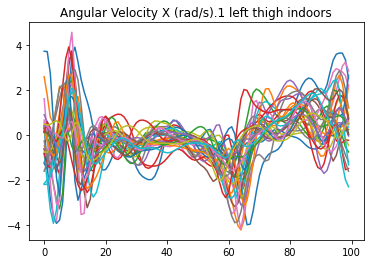

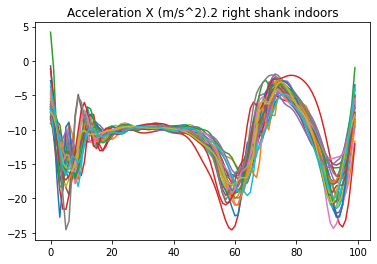

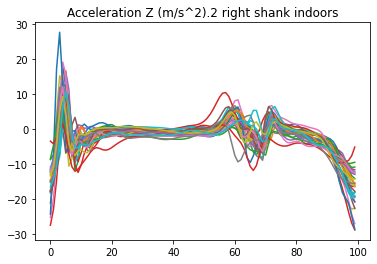

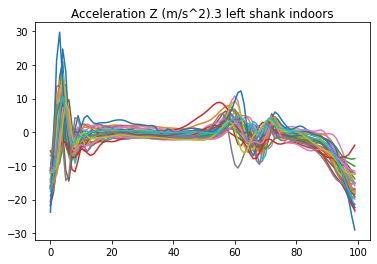

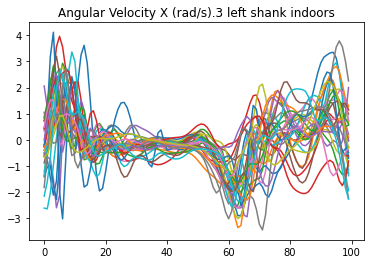

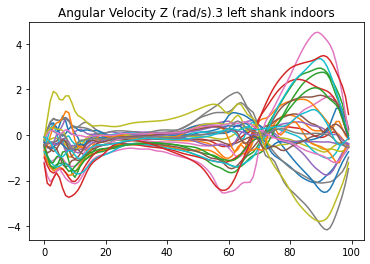

In [142]:
start = datetime.datetime.now()

save_dir = os.path.join("Analysis", "data_each_subject_each_sensor")
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
df_columns = ['subjectID', 'avg-or-std', *[str(x) for x in range(100)]]
for inout in ['outdoors', 'indoors']:
  for column_to_graph in COLUMNS_TO_GRAPH:
    fig, ax = plt.subplots()
    df_sensor_subject = pd.DataFrame([], columns=df_columns) 
    for subject_id in  metadata['subjectID'].unique():
      #column_to_graph = COLUMNS_TO_GRAPH[random.randint(0,len(COLUMNS_TO_GRAPH)-1)]
      all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, column_to_graph, inout , subject_id, pace=PACE)
      avg = all_gates.mean(axis=0)
      std = all_gates.std(axis=0)
      row = pd.DataFrame([[subject_id, 'avg', *avg ]], columns=df_columns)
      df_sensor_subject = pd.concat([df_sensor_subject,row ])
      row = pd.DataFrame([[subject_id,'std', *std ]], columns=df_columns)
      df_sensor_subject = pd.concat([df_sensor_subject,row ])
      ax.plot(avg, label=str(subject_id))
    _= ax.set_title(column_to_graph+ ' '+COLUMNS_TO_AREA[column_to_graph] + ' ' + inout) 
    filename = column_to_graph.replace(os.path.sep, '-').replace(' ','_') + '_' + COLUMNS_TO_AREA[column_to_graph] + '_' + inout+'.csv'
    df_sensor_subject.to_csv(os.path.join(save_dir,filename), index=False)
    fig.savefig(os.path.join(save_dir,filename.replace('.csv', '.png')))
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

## Extract Peak Values Per Subject

In [106]:
def get_filenames_single_subject(metadata, subjectID, inout, pace):
  where_cond = ((metadata['subjectID']==subjectID)&(metadata['inout']==inout)&(metadata['pace']==pace))
  records = metadata[where_cond]
  return records.filename.values
def get_zeros_crossings_single_subject(metadata, subjectID, inout, pace):
    filenames_p_subject = get_filenames_single_subject(metadata, subjectID, inout, pace)
    zero_crossings = []
    for filename in filenames_p_subject:
      if len(zero_crossing_lookup[filename][leg])==1:
        print(zero_crossing_lookup[filename][leg])
      zero_crossings.extend( zero_crossing_lookup[filename][leg])    
    if len(zero_crossings)==0:
      print("subject", subjectID, 'inout', inout)
    return zero_crossings 

In [98]:
def calculate_peaks_valley_range(all_gates):
  peaks = np.zeros(all_gates.shape[0])
  valleys = np.zeros(all_gates.shape[0])
  for i in range(all_gates.shape[0]):
    peaks[i] = max_peak(all_gates[i])[1]
    if len(all_gates[i]) <1:
      print(all_gates[i])
      raise ValueError
    valleys[i] = find_lowest_valley(all_gates[i])[1]
  return peaks, valleys, peaks-valleys
def assign_peak_valley_values(df, maxes, valleys, ranges, row_ind):
  df_peak_subject["avg_peak"].iloc[row_ind]=maxes.mean()
  df_peak_subject["std_peak"].iloc[row_ind]=maxes.std()
  df_peak_subject["avg_valley"].iloc[row_ind]=valleys.mean()
  df_peak_subject["std_valley"].iloc[row_ind]=valleys.std()
  df_peak_subject["avg_range"].iloc[row_ind]=ranges.mean()
  df_peak_subject["std_range"].iloc[row_ind]=ranges.std()  

def assign_peak_valley_each_file(df_peak_subject, data_lookup, sensor, zero_crossing_lookup):
  for row_ind in range(df_peak_subject.shape[0]):
    data_file = df_peak_subject.filename.iloc[row_ind]
    df_1 = data_lookup[data_file].copy()
    min_val = abs(df_1[sensor].min())
    df_1[sensor]=df_1[sensor].apply(lambda x: x/min_val)
    zero_crossings = zero_crossing_lookup[data_file][COLUMNS_TO_LEG[sensor]]
    _, _ , all_gates = calc_avg_std_gates(df_1, zero_crossings, sensor)
    peaks, valleys, ranges = calculate_peaks_valley_range(all_gates)
    assign_peak_valley_values(df, peaks, valleys, ranges, row_ind)  

right and left shank values are both included in the hist


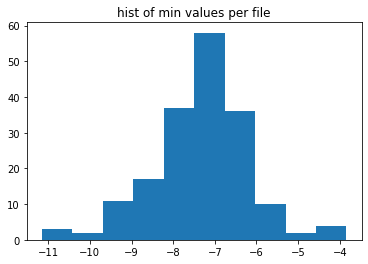

In [119]:
min_lookup = {}
all_mins = []
for file in data_lookup.keys():
  min_lookup[file] ={'left': data_lookup[file][LEFT_AVY_HEADER].min(), 'right':data_lookup[file][RIGHT_AVY_HEADER].min()}
  all_mins.append(data_lookup[file][LEFT_AVY_HEADER].min())
  all_mins.append(data_lookup[file][RIGHT_AVY_HEADER].min())
plt.hist(all_mins)
plt.title("hist of min values per file")
print("right and left shank values are both included in the hist")

In [110]:
filenames_p_subject = get_filenames_single_subject(metadata, 1, 'indoors', PACE)
zero_crossings = []
for filename in filenames_p_subject:
  zero_crossings.extend( zero_crossing_lookup[filename][leg])  

In [143]:
zero_crossings

[(34, 176),
 (177, 325),
 (326, 469),
 (470, 616),
 (617, 765),
 (921, 1069),
 (1070, 1219),
 (1220, 1366),
 (1829, 1980),
 (1981, 2128),
 (2129, 2280),
 (2281, 2432),
 (2433, 2580),
 (2581, 2725),
 (2726, 2866),
 (2867, 3010),
 (3011, 3153),
 (3154, 3301),
 (3302, 3448),
 (3449, 3596),
 (3597, 3744),
 (3745, 3889),
 (3890, 4034),
 (4175, 4317),
 (4318, 4459),
 (4460, 4606),
 (4607, 4748),
 (4749, 4893),
 (4894, 5040),
 (5041, 5187),
 (5188, 5333),
 (5334, 5482),
 (5483, 5632),
 (5633, 5780),
 (5781, 5929),
 (5930, 6076),
 (6077, 6225),
 (6226, 6374),
 (6375, 6522),
 (6523, 6669),
 (6670, 6815),
 (6816, 6964),
 (6965, 7108),
 (7109, 7253),
 (7254, 7400),
 (7401, 7548),
 (7549, 7699),
 (7854, 8005),
 (8006, 8152),
 (8153, 8297),
 (8298, 8441),
 (8442, 8588),
 (8589, 8734),
 (8735, 8878),
 (8879, 9022),
 (9023, 9169),
 (9170, 9312),
 (9313, 9458),
 (9459, 9601),
 (9602, 9748),
 (9749, 9894),
 (9895, 10038),
 (10039, 10184),
 (10185, 10329),
 (10330, 10477),
 (10478, 10629),
 (10630, 1078

In [ ]:
get_zeros_crossings_single_subject(metadata, 1, 'indoors', PACE)

In [122]:
type(all_gates[0])

numpy.ndarray

In [120]:
(all_gates/all_gates.min()).min()

-1.0900546508874547

In [125]:
peaks.max()

1.0

In [93]:
len(zero_crossings)

290

In [130]:
avxyz_cols = []
for col in [RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:
  avxyz_cols.extend([col, col.replace('Y', 'X'), col.replace('Y','Z')])
avxyz_cols

['Angular Velocity Y (rad/s).2',
 'Angular Velocity X (rad/s).2',
 'Angular Velocity Z (rad/s).2',
 'Angular Velocity Y (rad/s).3',
 'Angular Velocity X (rad/s).3',
 'Angular Velocity Z (rad/s).3']

In [135]:
start = datetime.datetime.now()

save_dir = os.path.join("Analysis", "peaks_per_subject")
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
all_mins = []
columns = ['sensor', 'subjectID','inout', 'area',
           'avg_gate_length','std_gate_length', 'max_gate_length','min_gate_length',
           "avg_peak", "std_peak","max_peak", "min_peak", 
           "avg_valley", "std_valley","max_valley", "min_valley", 
           "avg_range", "std_range", 'max_range', 'min_range']
avxyz_cols = []
for col in [RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:
  avxyz_cols.extend([col, col.replace('Y', 'X'), col.replace('Y','Z')])
for sensor in avxyz_cols:
  df_filename = sensor.replace(os.path.sep, '-')+'_'+PACE
  data = []
  leg = COLUMNS_TO_LEG[sensor]
  area = COLUMNS_TO_AREA[sensor]
  df_filename += "_"+area+'.csv'
  for i, inout in enumerate(['indoors', 'outdoors']):
    for subject_id in  metadata['subjectID'].unique():
      ##measure peak, valley, range, gate length all averages and std
      all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, column_to_graph, inout , subject_id, pace=PACE)
      bounded_gates = (all_gates/abs(all_gates.min()))
      peaks, valleys, ranges = calculate_peaks_valley_range(bounded_gates)
      #assign_peak_valley_each_file(df_peak_subject, data_lookup, sensor, zero_crossing_lookup)
      row = {'sensor':sensor, 'subjectID':subjectID, 'inout':inout, 'area':area,
                  "avg_peak":peaks.mean(),"std_peak":peaks.std(),
                        "max_peak":peaks.max(), "min_peak":peaks.min(), 
                  "avg_valley":valleys.mean(), "std_valley": valleys.std(), 
                        "max_valley":valleys.max(), "min_valley":valleys.min(), 
                  "avg_range":ranges.mean(), "std_range":ranges.std(),                
                        'max_range':ranges.max(), 'min_range':ranges.min()}
      if 'Y' in sensor:
        zero_crossings = get_zeros_crossings_single_subject(metadata, subjectID, inout, PACE)
        avg_gate_lengths,std_gate_lengths, max_gate_lengths, min_gate_lengths  = avg_std_gate_lengths(zero_crossings)
        row.update({'avg_gate_length':avg_gate_lengths,'std_gate_length':std_gate_lengths,
                      'max_gate_length':max_gate_lengths,'min_gate_length':min_gate_lengths})
      data.append(row )
  df_peak_subject = pd.DataFrame(data, columns=columns)
  df_peak_subject.to_csv(os.path.join(save_dir, df_filename), index=False)

print("took", (datetime.datetime.now()-start).total_seconds(), "to run")


took 27.907636 to run


## Combine Gate Data from Single Sensor - Across Subjects

### Graphing Aggregated Signals

In [148]:
##to combine different trials, group by 'subjectID', 'pace', 'inout', 
##  then loop through all df's created in the group by iterable. in each df, 
##  if more than one row exists, concatenate the data from the rows
def aggregate_subjects_trials(data_lookup, metadata: pd.core.frame.DataFrame, zero_crossing_lookup: dict, column_to_graph:str, inout:str = 'indoors', pace = PACE):
  '''given one column to focus on, it combines all the data across all the files and subjects.
  inout could be either [indoors, outdoors]'''
  agg_gates  = None
  for subject_id in  metadata['subjectID'].unique():
    all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, column_to_graph, inout , subjectID, pace=pace)
    if type(agg_gates)==np.ndarray:
     agg_gates = np.concatenate((agg_gates,all_gates),axis=0)
    else: 
     agg_gates=all_gates
  return agg_gates

In [137]:
def plot_columns_inout(data_lookup, metadata: pd.core.frame.DataFrame, zero_crossing_lookup: dict, column_to_graph:str, inout:str = 'indoors'):
  agg_gates=aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,column_to_graph, inout )
  avg = agg_gates.mean(axis=0)
  std = agg_gates.std(axis=0)
  fig, ax = plt.subplots()
  ax.plot(avg, color='black')
  ax.set_xlabel("normalized time")
  ax.set_ylabel("signal")
  label_axis(column_to_graph, ax)

  ax.fill_between(np.arange(0,100), avg-std, avg+std, alpha=0.4, color='gray')
  _= ax.set_title(column_to_graph+ ' '+COLUMNS_TO_AREA[column_to_graph] + ' ' + inout) 

In [152]:
##PICK ONE DATA STREAM AT A TIME
column_to_graph = COLUMNS_TO_GRAPH[random.randint(0,len(COLUMNS_TO_GRAPH)-1)]
inout='indoors'
plot_columns_inout(data_lookup, metadata, zero_crossing_lookup,column_to_graph, inout)

In [153]:
def graph_sensors_combined_subjects_trials(save_dir, data_lookup, metadata, zero_crossing_lookup):
  '''graph all data streams indoors, then outdoors aggregated across all subjects 
     and trials. only aggregates across two trials. if more exist, they are ignored'''
  for column_to_graph in COLUMNS_TO_GRAPH:
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    for i, inout in enumerate(['indoors', 'outdoors']):
      agg_gates=aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,column_to_graph, inout )
      avg = agg_gates.mean(axis=0)
      std = agg_gates.std(axis=0)
      ax[i].plot(avg, color='black')
      label_axis(column_to_graph, ax[i])

      ax[i].fill_between(np.arange(0,100), avg-std, avg+std, alpha=0.4, color='gray')
      title = column_to_graph+ ' '+COLUMNS_TO_AREA[column_to_graph]
      _= ax[i].set_title(title + ' ' + inout)
    fig.savefig(os.path.join(save_dir,title.replace(os.path.sep, '-')+'.png'))  

<ipython-input-153-46200ab3eff5>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
<ipython-input-153-46200ab3eff5>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
<ipython-input-153-46200ab3eff5>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcPar

took 91.658724 to run


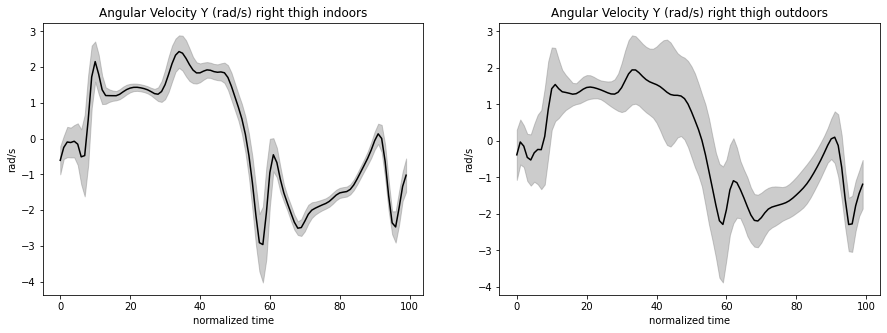

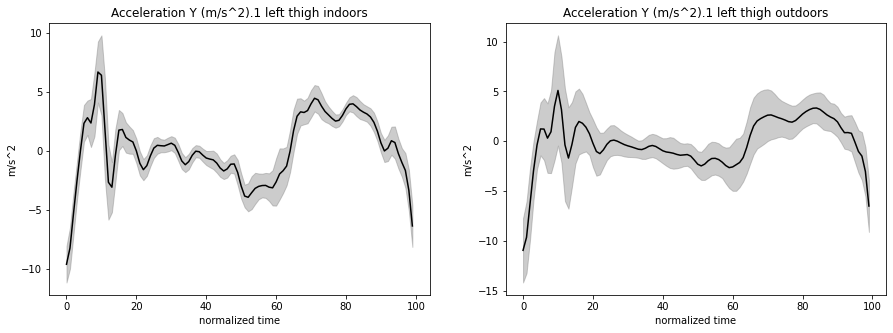

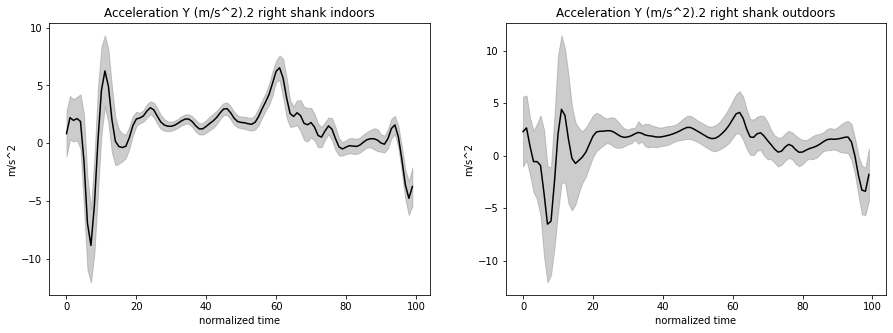

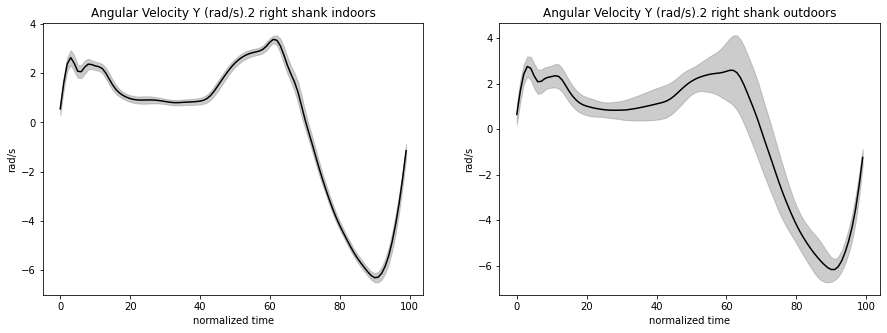

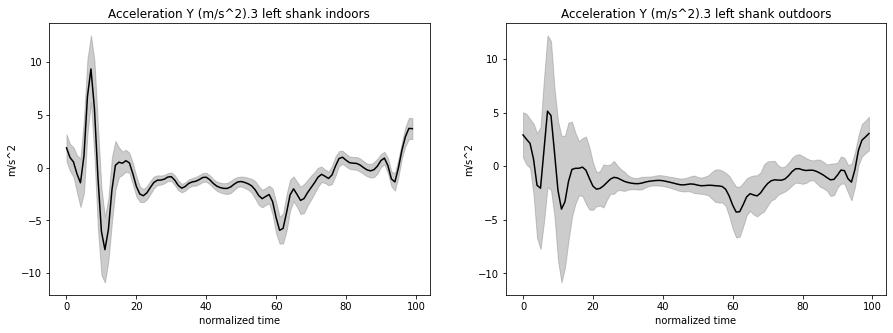

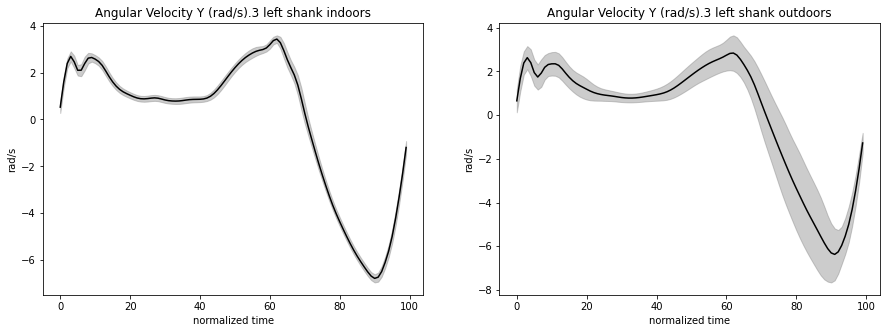

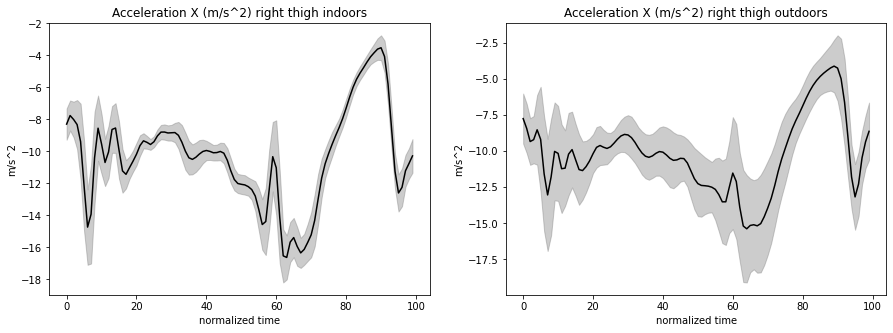

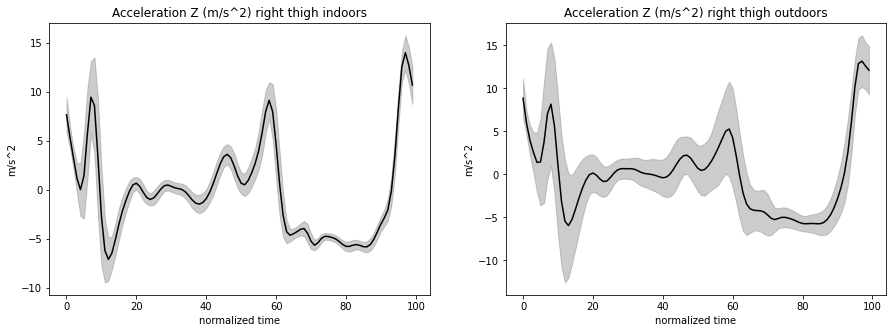

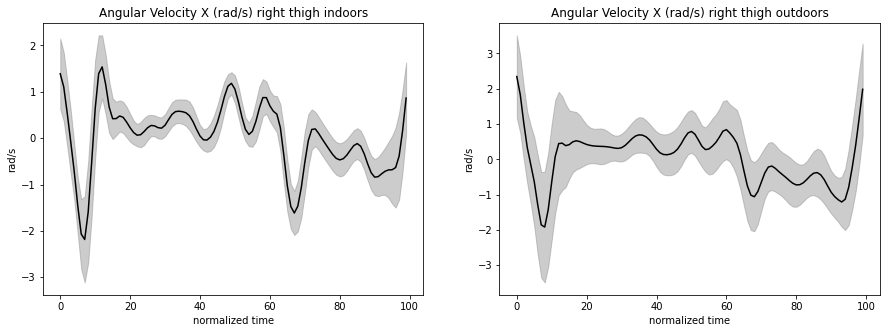

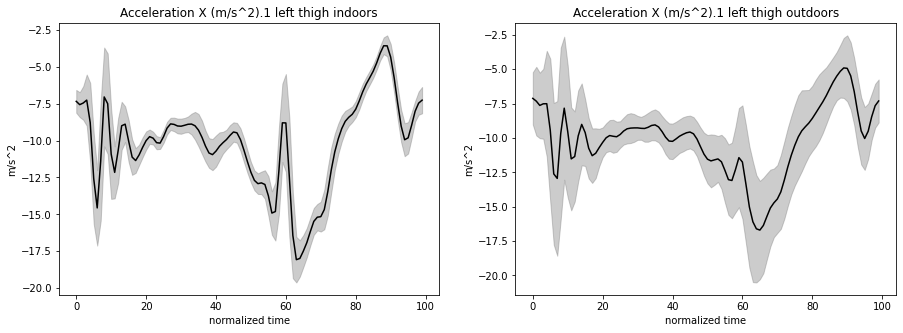

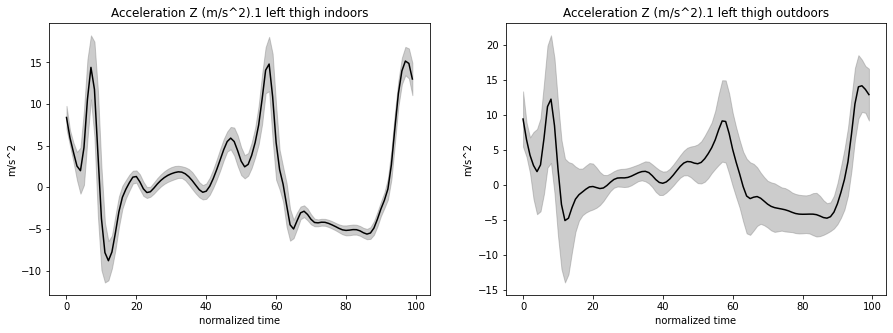

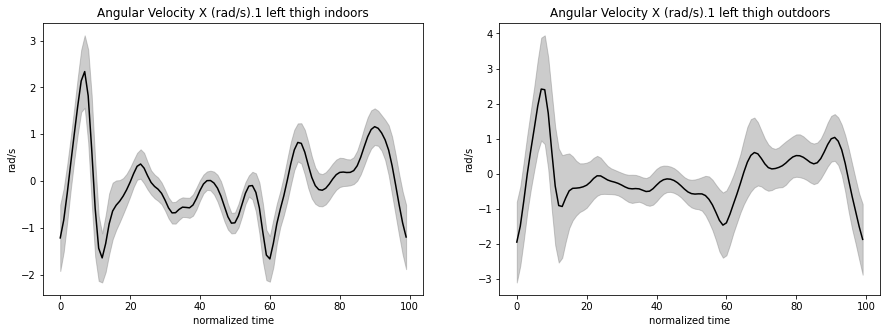

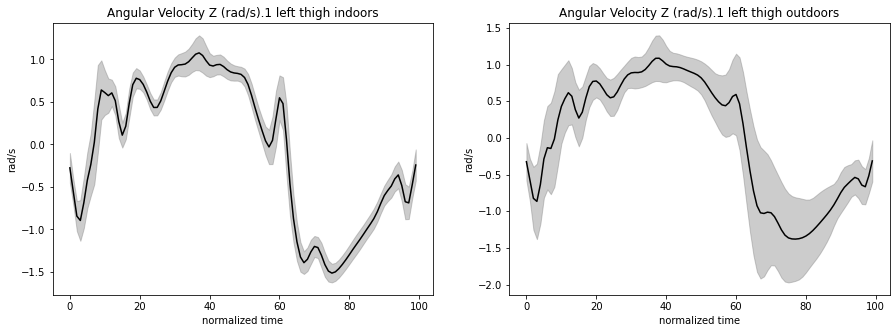

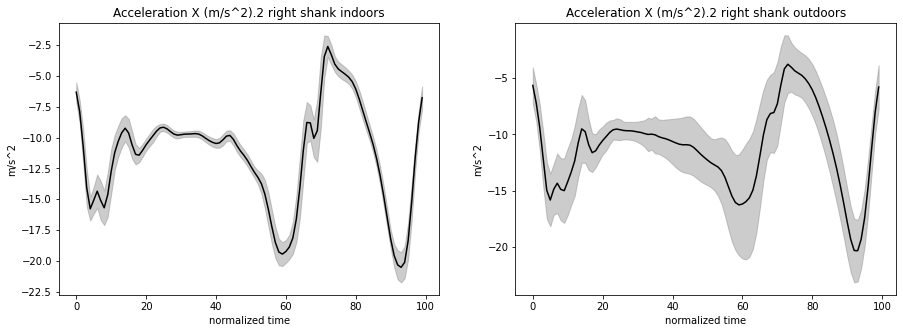

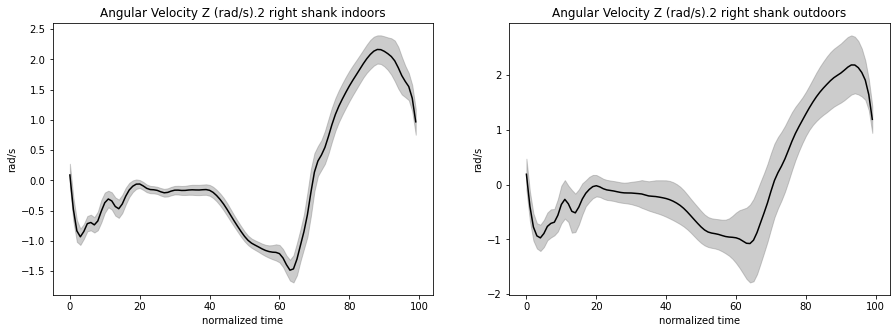

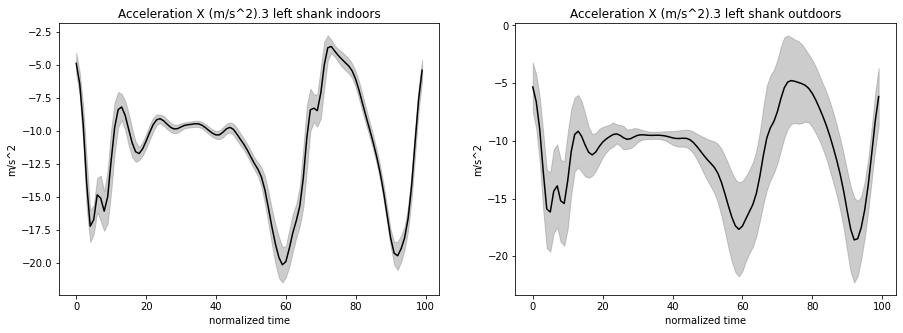

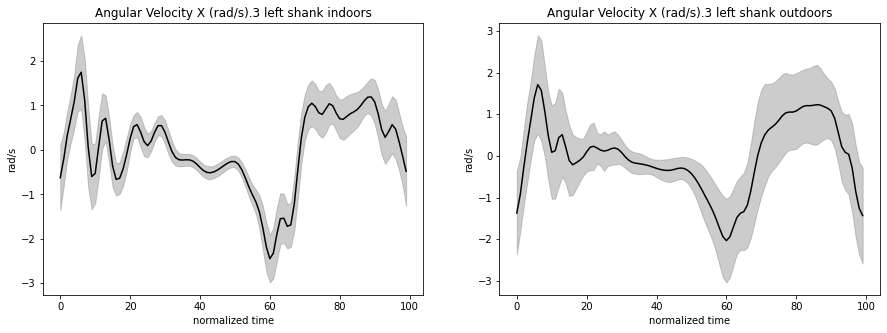

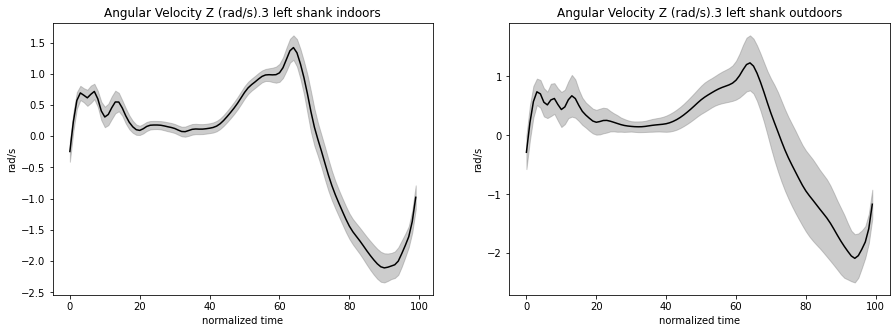

In [154]:
start = datetime.datetime.now()
save_dir = os.path.join('Analysis', 'combined_subjects_and_trials')
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
graph_sensors_combined_subjects_trials(save_dir, data_lookup, metadata, zero_crossing_lookup)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

### Signal Stats

In [155]:
##for all data streams indoors, then outdoors. get max, min, range, avg, 
##  std values. max and min values are from the raw signal per gate 
##  not from the averaged values.
start = datetime.datetime.now()

print("all values presented are done by analyzing a list of size ~9,198. Where each element in the list is a gate profile. Meaning the average min is the average of ~9,198 minimum values")
global_mins = []
ranges = []
range_std = []
global_maxes = []
storing_data = []
for column_to_graph in COLUMNS_TO_GRAPH:
  for i, inout in enumerate(['indoors', 'outdoors']):
    agg_gates=aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,column_to_graph, inout )
    maxes_of_all_gates_trails = agg_gates.max(axis=1)
    mins_of_all_gates_trails = agg_gates.min(axis=1)
    ranges_of_all_gates_trails = np.subtract(maxes_of_all_gates_trails, mins_of_all_gates_trails)
    #print("")
    #print('\n',column_to_graph, COLUMNS_TO_AREA[column_to_graph], inout)
    global_min = mins_of_all_gates_trails.min()
    #print('\t', "global min" ,global_min )
    global_mins.append(global_min)
    avg_min = mins_of_all_gates_trails.mean()
    #print("\t","avg min",avg_min  )
    std_min = mins_of_all_gates_trails.std()
    #print("\t","std min", std_min )
    global_max = maxes_of_all_gates_trails.max()
    #print('\t', "global max" , global_max)
    global_maxes.append(global_max)
    avg_range = ranges_of_all_gates_trails.mean()
    #print('\t', "avg range" ,avg_range )
    ranges.append(avg_range)
    std_range = ranges_of_all_gates_trails.std()
    #print('\t', "std range" , std_range)
    range_std.append(std_range)
    number_of_gates = maxes_of_all_gates_trails.shape[0]
    #print("number of gates",number_of_gates)
    
    storing_data.append([column_to_graph, COLUMNS_TO_AREA[column_to_graph], inout,global_min, avg_min,std_min,global_max, avg_range, std_range,number_of_gates ])
storing_data_df = pd.DataFrame(storing_data, columns=['column_to_graph', 'area', 'inout','global_min', 'avg_min','std_min','global_max', 'avg_range', 'std_range','number_of_gates'])
storing_data_df.to_csv(os.path.join("Analysis", 'combined_subjects_trials_signal_stats.csv'))
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

all values presented are done by analyzing a list of size ~9,198. Where each element in the list is a gate profile. Meaning the average min is the average of ~9,198 minimum values
took 79.791618 to run


Text(0.5, 0, 'global minimum of single data stream')

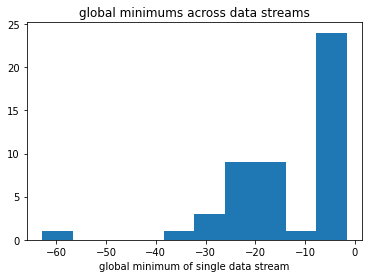

In [156]:
plt.hist(global_mins)
plt.title('global minimums across data streams')
plt.xlabel("global minimum of single data stream")

Text(0.5, 0, 'global maximum of single data stream')

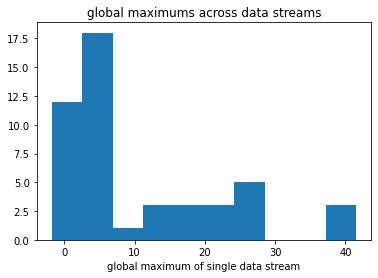

In [157]:
plt.hist(global_maxes)
plt.title('global maximums across data streams')
plt.xlabel("global maximum of single data stream")

Text(0.5, 0, 'amplitude range of a single data stream')

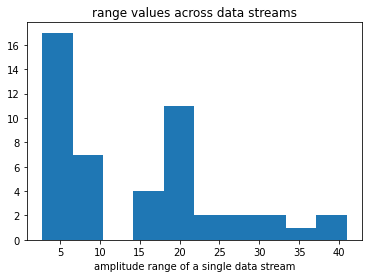

In [158]:
plt.hist(ranges)
plt.title('range values across data streams')
plt.xlabel("amplitude range of a single data stream")

## Combine Subjects, Trials, and Legs

In [168]:
combined_legs = {}
combined_legs['4'] = 3

In [191]:
def graph_aggregate_subjects_trials_legs(save_dir, data_lookup, metadata: pd.core.frame.DataFrame, zero_crossing_lookup: dict):
  '''for each sensor, aggregate the signal from all subjects and trials and add 
  on the signals for each leg together. So that you get one signal for each 
  sensor for indoor/outdoor for both legs.
  also graph the mean of each leg seperately on the same plot so you can see 
  what they look like before the averaging.
  return the mean and std of the combined signal'''
  combined_legs = {}
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  for sensor_cols in COLUMNS_BY_SENSOR:
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    fig2, ax2 = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    sensor_look = sensor_cols['left'].replace(".1","").replace(".3","")
    combined_legs[sensor_look] = {}
    for i, inout in enumerate(['indoors', 'outdoors']):
      left_gates  =aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,sensor_cols['left'], inout )
      right_gates =aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,sensor_cols['right'], inout )
      agg_gates = np.concatenate((left_gates,right_gates),axis=0)
      avg = agg_gates.mean(axis=0)
      std = agg_gates.std(axis=0)  

      ax2[i].plot(left_gates.mean(axis=0), label='left')
      ax2[i].plot(right_gates.mean(axis=0), label='right')
      ax2[i].set_xlabel("normalized time")
      ax2[i].set_ylabel("signal")
      title2 = sensor_cols['left']+ ' '+'each leg'+' '+sensor_cols['sensor'] 
      _= ax2[i].set_title(title2+ ' ' + inout) 
      fig2.savefig(os.path.join(save_dir,title2.replace(os.path.sep, '-')+'.png'))

      ax[i].plot(avg, color='black')
      ax[i].set_xlabel("normalized time")
      ax[i].set_ylabel("signal")
      ax[i].fill_between(np.arange(0,100), avg-std, avg+std, alpha=0.4, color='gray')
      title = sensor_cols['left']+ ' '+'both legs'+' '+sensor_cols['sensor'] 
      _= ax[i].set_title(title+ ' ' + inout) 
      fig.savefig(os.path.join(save_dir,title.replace(os.path.sep, '-')+'.png'))
      combined_legs[sensor_look][inout] = {'avg': avg, 'std':std}
  return combined_legs

In [ ]:
start = datetime.datetime.now()
save_dir = os.path.join('Analysis', 'combined_subjects_and_trials_and_legs')
combined_legs = graph_aggregate_subjects_trials_legs(save_dir, data_lookup, metadata, zero_crossing_lookup)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

In [173]:
combined_legs.keys()

dict_keys(['Acceleration Y (m/s^2).1', 'Angular Velocity Y (rad/s).1', 'Acceleration Y (m/s^2).3', 'Angular Velocity Y (rad/s).3', 'Acceleration X (m/s^2).1', 'Acceleration Z (m/s^2).1', 'Angular Velocity X (rad/s).1', 'Angular Velocity Z (rad/s).1', 'Acceleration X (m/s^2).3', 'Acceleration Z (m/s^2).3', 'Angular Velocity X (rad/s).3', 'Angular Velocity Z (rad/s).3'])

# Signal Similarity Metrics

Find Cross Correlations between indoors vs outdoors and calculate the euclidean and cosine distances 

## Correlations


In [176]:
def get_signal_indoors_outdoors(data_lookup, metadata, zero_crossing_lookup, column_to_graph):
  '''returns: np array of avg signal'''
  agg_gates=aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,column_to_graph, 'indoors' )
  signal_indoors = agg_gates.mean(axis=0)
  agg_gates=aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,column_to_graph, 'outdoors' )
  signal_outdoors = agg_gates.mean(axis=0)  
  return signal_indoors, signal_outdoors

In [177]:
def normalize_signal_by_range(indoor, outdoor):
  '''takes in indoor and outdoor signals and divides all numbers by the range
  the purpose is s.t. the signal strength won't impact the result of the 
  cross correlation since the goal of the cross correlation is s.t.
  it compares signal shapes, not amplitudes'''
  inrange = indoor.max()-indoor.min()
  outrange = outdoor.max()-outdoor.min()
  return indoor/inrange, outdoor/outrange

### Mess With Single Column

In [183]:
column_to_graph= COLUMNS_TO_GRAPH[np.random.randint(low=0, high=len(COLUMNS_TO_GRAPH))]
signal_indoors, signal_outdoors=get_signal_indoors_outdoors(data_lookup, metadata, zero_crossing_lookup, column_to_graph)
signal_indoors, signal_outdoors=normalize_signal_by_range(signal_indoors, signal_outdoors)

In [ ]:
corr = correlate(signal_indoors, signal_outdoors)
peak_indices , peak_values = max_peak(corr)
#vallen_indices = 
max_index =peak_values.index(max(peak_values))
auto_corr = correlate(signal_indoors, signal_indoors)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
ax[0].scatter(peak_indices, peak_values, color='red')
ax[0].plot(corr)
ax[0].scatter([peak_indices[max_index]],[peak_values[max_index]], color='black' )
_=ax[0].set_title("cross correlation")
x,y = max_peak(auto_corr)
ax[1].plot(auto_corr)
ax[1].set_title("auto correlation")
ax[1].scatter(x,y, color='black')
##divide by two since the length of the correlation is double the input signal
corr_delay = peak_indices[max_index]/2 - x/2
print("delay between signals", corr_delay)

delay between signals 0.0


### Measure and Save for all Columns

In [179]:
def measure_correlation(signal_indoors, signal_outdoors, verbose=False):
  corr = correlate(signal_indoors, signal_outdoors)
  peak_corr = max_peak(corr)
  auto_corr = correlate(signal_indoors, signal_indoors)
  peak_auto_corr = max_peak(auto_corr)
  corr_delay = peak_corr[0]/2 - peak_auto_corr[0]/2
  normalized_correlation = peak_corr[1]/ peak_auto_corr[1]
  if verbose:
    print("\nsensor:", column_to_graph, COLUMNS_TO_AREA[column_to_graph])
    print(" correlation peak divided by auto-correlation amplitude",normalized_correlation )
    print("delay between signals", round(corr_delay), 'data points')    
  return normalized_correlation

In [180]:
def measure_euclidean(indoors, outdoors):
  norm_signal_indoors = indoors/ np.linalg.norm(indoors)
  norm_signal_outdoors = outdoors/ np.linalg.norm(outdoors)
  return distance.euclidean(norm_signal_indoors, norm_signal_outdoors)  

In [184]:
def signal_similarity(metadata, zero_crossing_lookup, save_dir, verbose=False):
  similarity_data =[]
  for column_to_graph in COLUMNS_TO_GRAPH:
    indoors, outdoors=get_signal_indoors_outdoors(data_lookup, metadata, zero_crossing_lookup, column_to_graph)
    indoors_normrange, outdoors_normrange=normalize_signal_by_range(indoors, outdoors)
    correlation_normrange= measure_correlation(indoors_normrange, outdoors_normrange, verbose=False)
    euc = measure_euclidean(indoors, outdoors)
    cos = np.dot(indoors,outdoors)/(np.linalg.norm(indoors)*np.linalg.norm(outdoors))
    if verbose:
      print('\n',column_to_graph, COLUMNS_TO_AREA[column_to_graph],'\n','indoors vs outdoors ', "\nCosine Similarity:" , cos)
      print("Euclidean Distance:", euc)  
    similarity_data.append([column_to_graph, COLUMNS_TO_AREA[column_to_graph],cos, euc, correlation_normrange])
  sim_df = pd.DataFrame(similarity_data, columns=['column_to_graph', 'area', 'cosine_similarity', 'euclidean_distance', 'correlation_peak_divided_by_auto-correlation_amplitude'])
  sim_df.to_csv(os.path.join(save_dir, "signal_similarity.csv"))


In [187]:
start = datetime.datetime.now()
signal_similarity(metadata, zero_crossing_lookup, "Analysis")
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")


took 78.838536 to run


In [189]:
combined_legs.keys()

dict_keys(['Acceleration Y (m/s^2)', 'Angular Velocity Y (rad/s)', 'Acceleration X (m/s^2)', 'Acceleration Z (m/s^2)', 'Angular Velocity X (rad/s)', 'Angular Velocity Z (rad/s)'])

## Signal Similarity for Same Leg

In [188]:
start = datetime.datetime.now()
save_dir = os.path.join('Analysis', 'combined_subjects_and_trials_and_legs')
columns=['sensor', 'cosine_similarity', 'euclidean_distance', 'correlation_peak_divided_by_auto-correlation_amplitude']
leg_similarities = []
for sensors in list(combined_legs.keys()):
  indoors = combined_legs[sensors]['indoors']['avg']
  outdoors = combined_legs[sensors]['outdoors']['avg']
  indoors_normrange, outdoors_normrange = normalize_signal_by_range(indoors, outdoors)
  correlation_normrange= measure_correlation(indoors_normrange, outdoors_normrange, verbose=False)
  euc = measure_euclidean(indoors, outdoors)
  cos = np.dot(indoors,outdoors)/(np.linalg.norm(indoors)*np.linalg.norm(outdoors))
  leg_similarities.append([sensors, cos, euc, correlation_normrange])
sim_df = pd.DataFrame(leg_similarities, columns=columns)
sim_df.to_csv(os.path.join(save_dir, "signal_similarity_combined_legs.csv"))  
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")


took 0.278306 to run


In [190]:
save_dir

'Analysis/combined_subjects_and_trials_and_legs'

# Explore the smaller gates

using the graph_zero_crossings function, set the gate_max value to a low value to show only the short gates. this gives some intuition to where potential error sources are.

20220817-105702-subject_01inw1.csv
20220820-195205-subject_02inw1.csv
20220823-134741-subject_03inw2.csv
20220824-111447-subject_04inw2.csv
20220825-101234-subject_05inw2.csv
20220825-131631-subject_06inw2.csv
20220825-145335-subject_07inw2.csv
20220825-175347-subject_08inw1.csv
20220828-120351-subject_09inw2.csv
20220829-100939-subject_10inw1.csv
20220829-130947-subject_11inw2.csv
20220830-112727-subject_12inw2.csv
20220831-101429-subject_13inw1.csv
20220831-104207-subject_14inw1.csv
20220918-101129-subject_15inw2.csv
20221009-095850-subject_16inw2.csv
20221009-172428-subject_17inw2.csv
20221009-183118-subject_18inw1.csv
20221023-101720-subject_19inw1.csv
20221029-173346-subject_20inw2.csv
20221030-100150-subject_21inw1.csv
20221030-122014-subject_22inw2.csv
20221103-164221-subject_23inw1.csv
20221105-120406-subject_24inw2.csv
20221106-105627-subject_25inw2.csv
20221113-101119-subject_26inw1.csv
20221113-112119-subject_27inw2.csv
20221113-161518-subject_28inw2.csv
20221113-171429-subj

<ipython-input-11-dbd2e45ec838>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b[col]=pd.Series(filtered, name=col)


20220817-105702-subject_01inw1.csv
20220820-195205-subject_02inw1.csv
20220823-134741-subject_03inw2.csv
20220824-111447-subject_04inw2.csv
20220825-101234-subject_05inw2.csv
20220825-131631-subject_06inw2.csv
20220825-145335-subject_07inw2.csv
20220825-175347-subject_08inw1.csv
20220828-120351-subject_09inw2.csv
20220829-100939-subject_10inw1.csv
20220829-130947-subject_11inw2.csv
20220830-112727-subject_12inw2.csv
20220831-101429-subject_13inw1.csv
20220831-104207-subject_14inw1.csv
20220918-101129-subject_15inw2.csv
20221009-095850-subject_16inw2.csv
20221009-172428-subject_17inw2.csv
20221009-183118-subject_18inw1.csv
20221023-101720-subject_19inw1.csv
20221029-173346-subject_20inw2.csv
20221030-100150-subject_21inw1.csv
20221030-122014-subject_22inw2.csv
20220817-112946-subject_01onw1.csv
20220820-202012-subject_02onw1.csv
20220823-140901-subject_03onw1.csv
20220824-115324-subject_04onw1.csv
20220825-103542-subject_05onw1.csv
20220825-134000-subject_06onw1.csv
20220825-151331-subj

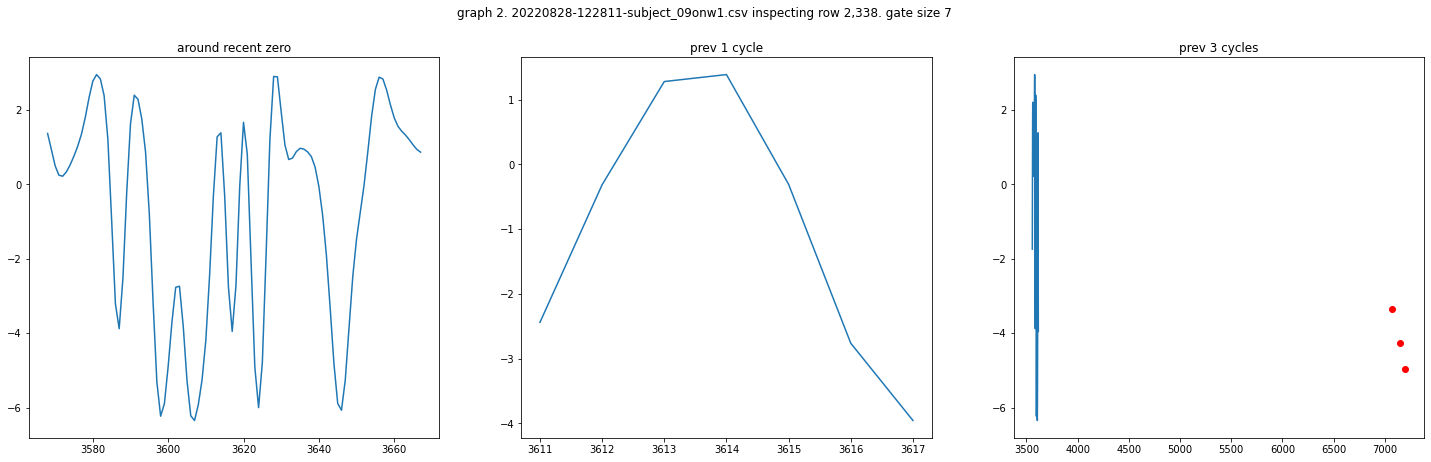

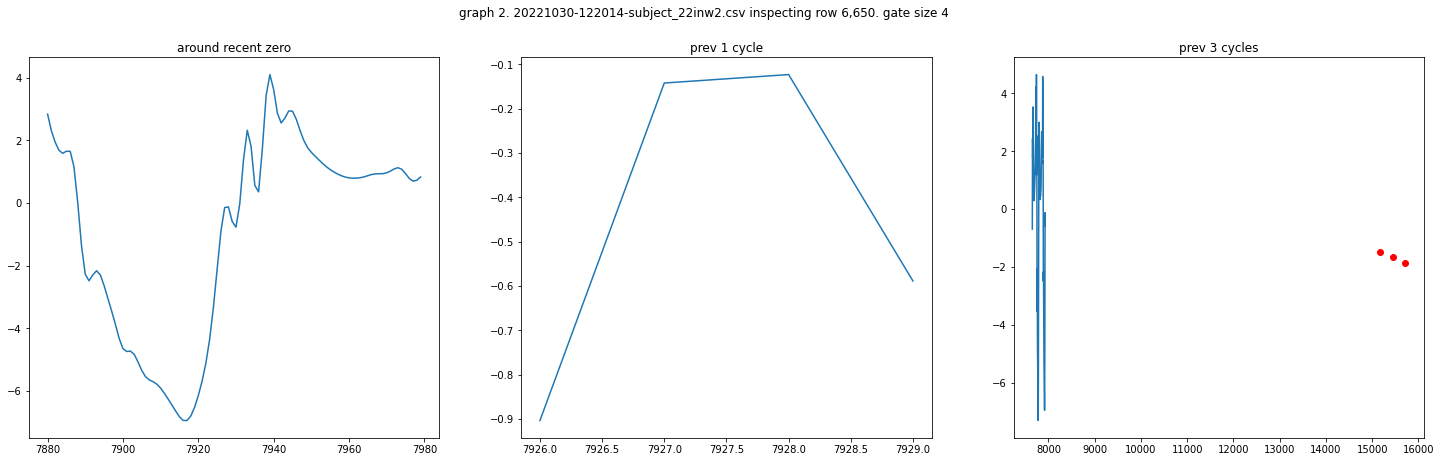

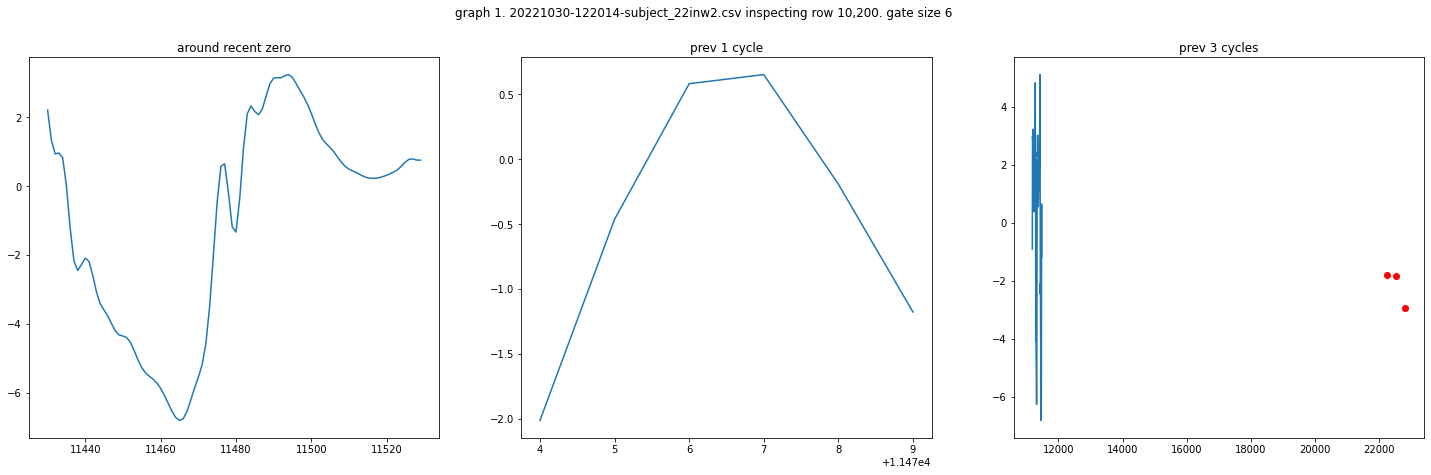

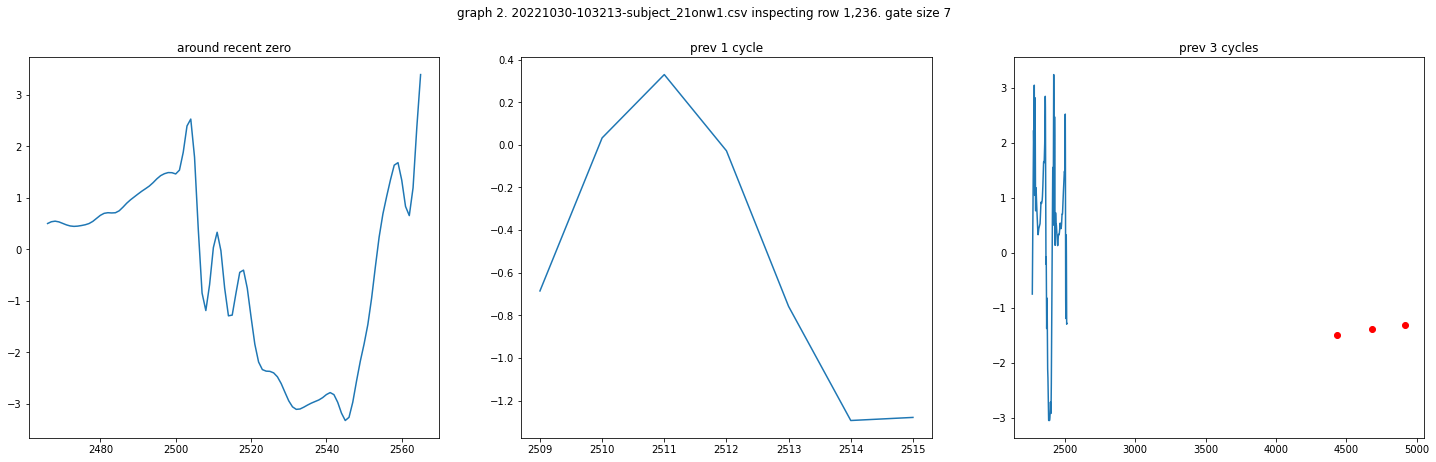

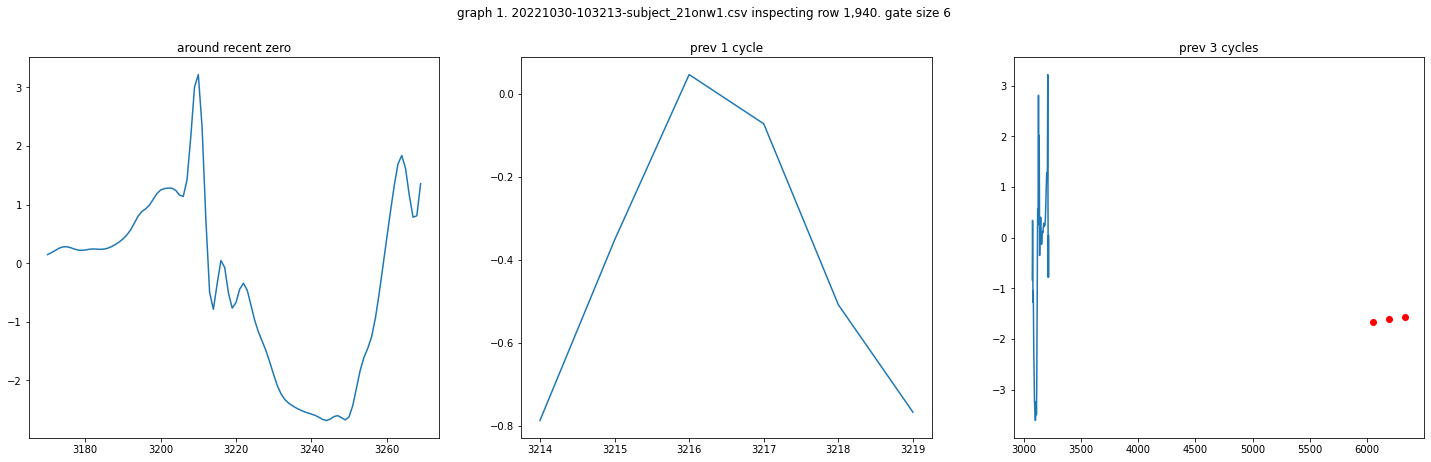

In [ ]:
graphs =0
#for gate_crossing in [0,-0.3, -0.6, -0.9]:
#zero_crossing_lookup=calc_all_gate_crossings(gate_crossing = gate_crossing)
for sensor_cols in [RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:
  for i, inout in enumerate(['indoors', 'outdoors']):
    all_gate_lengths = []
    for x in metadata[metadata['inout']==inout].groupby(by=['subjectID', 'pace']):
      df_trials=x[1]
      filename=df_trials['filename'].iloc[0]
      zero_crossings = zero_crossing_lookup[filename][COLUMNS_TO_LEG[sensor_cols]]
      avg, std , ppgmax, ppgmin = avg_std_gate_lengths(zero_crossings)
      #gate_starts = [x[0] for x in zero_crossings]
      print(filename)
      if ppgmin<10:
        graph_zero_crossings(zero_crossings,load_data(filename)[sensor_cols], filename , save_dir= 'gate_crossings', window= 50, graph_limit = 2, gate_max=10)
        graphs +=1
        break
  if graphs > 10:
    break

In [ ]:
graph_zero_crossings(zero_crossings_right, df[RIGHT_AVY_HEADER],file, save_dir= 'gate_crossings', window= 50, graph_limit = 20, gate_max=10)

# Exploring random points of data

In [ ]:
zero_crossings_right[:20]

[(51, 175),
 (175, 300),
 (300, 419),
 (419, 545),
 (545, 673),
 (673, 797),
 (797, 923),
 (923, 1055),
 (1055, 1185),
 (1185, 1312),
 (1312, 1443),
 (1443, 1575),
 (1575, 1697),
 (1697, 1827),
 (1827, 1958),
 (1958, 2088),
 (2088, 2214),
 (2214, 2340),
 (2340, 2467),
 (2467, 2593)]

Below are examples of the sizes of some of the gates

In [ ]:
points_p_gate[:20]

NameError: ignored

In [ ]:
##For graphing and saving individual regions
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax[0].plot(df[RIGHT_AVY_HEADER].iloc[775:783])
ax[1].plot(df[RIGHT_AVY_HEADER].iloc[1210:1220])
#fig.savefig("bad_cycle.png")